<a href="https://colab.research.google.com/github/rizkyprofs/ML_DL/blob/main/utsml1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline End-to-End untuk Regresi Machine Learning

Notebook ini mendemonstrasikan pipeline lengkap untuk regresi machine learning mengikuti langkah-langkah yang diperlukan:
1. Pengumpulan dan pembersihan data
2. Feature selection menggunakan berbagai teknik
3. Feature engineering
4. Pelatihan model dan evaluasi menggunakan berbagai metrik

Mari kita mulai dengan mengimpor semua library yang diperlukan.

# Pipeline End-to-End untuk Regresi Machine Learning

Notebook ini mendemonstrasikan pipeline lengkap untuk regresi machine learning mengikuti langkah-langkah yang diperlukan:
1. Pengumpulan dan pembersihan data
2. Feature selection menggunakan berbagai teknik
3. Feature engineering
4. Pelatihan model dan evaluasi menggunakan berbagai metrik

Mari kita mulai dengan mengimpor semua library yang diperlukan.

In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import time
import warnings
warnings.filterwarnings('ignore')

# Untuk preprocessing dan feature selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, VarianceThreshold, RFECV
from sklearn.decomposition import PCA

# Untuk model building dan evaluasi
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import (
    RandomForestRegressor, BaggingRegressor, AdaBoostRegressor,
    GradientBoostingRegressor, VotingRegressor
)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    mean_absolute_percentage_error, explained_variance_score
)

# Mengatur gaya plot
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis")

## 1. Pengumpulan dan Pembersihan Data

Pada langkah ini, kita akan memuat dataset, mengeksplorasi karakteristiknya, dan membersihkannya dengan menangani nilai yang hilang, duplikat, dan outlier.

LANGKAH 1: PENGUMPULAN DAN PEMBERSIHAN DATA

Informasi dataset:
Jumlah baris dan kolom: (515344, 91)

Sampel data (5 baris pertama):
   2001  49.94357  21.47114   73.0775   8.74861  -17.40628  -13.09905  \
0  2001  48.73215  18.42930  70.32679  12.94636  -10.32437  -24.83777   
1  2001  50.95714  31.85602  55.81851  13.41693   -6.57898  -18.54940   
2  2001  48.24750  -1.89837  36.29772   2.58776    0.97170  -26.21683   
3  2001  50.97020  42.20998  67.09964   8.46791  -15.85279  -16.81409   
4  2001  50.54767   0.31568  92.35066  22.38696  -25.51870  -19.04928   

   -25.01202  -12.23257   7.83089  ...   13.0162  -54.40548  58.99367  \
0    8.76630   -0.92019  18.76548  ...   5.66812  -19.68073  33.04964   
1   -3.27872   -2.35035  16.07017  ...   3.03800   26.05866 -50.92779   
2    5.05097  -10.34124   3.55005  ...  34.57337 -171.70734 -16.96705   
3  -12.48207   -9.37636  12.63699  ...   9.92661  -55.95724  64.92712   
4   20.67345   -5.19943   3.63566  ...   6.59753  -50.69577  26

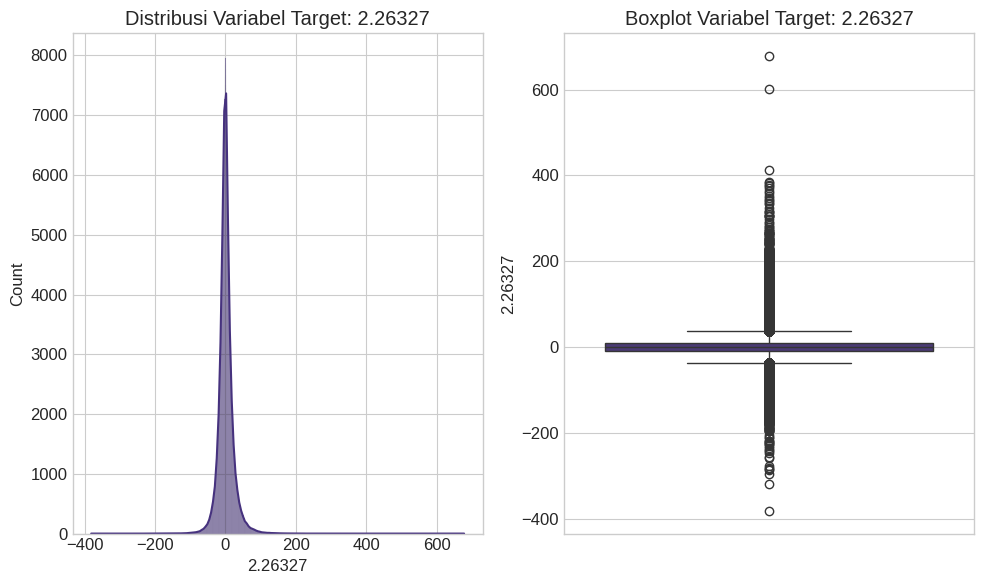

In [2]:
print("="*80)
print("LANGKAH 1: PENGUMPULAN DAN PEMBERSIHAN DATA")
print("="*80)

# Memuat dataset
url = "https://media.githubusercontent.com/media/KhalPrawira/Machine-Learning-Course/refs/heads/main/UTS/Dataset/RegresiUTSTelkom.csv"
df = pd.read_csv(url)

# Eksplorasi awal dataset
print("\nInformasi dataset:")
print(f"Jumlah baris dan kolom: {df.shape}")
print("\nSampel data (5 baris pertama):")
print(df.head())

print("\nInformasi tipe data:")
print(df.dtypes)

print("\nStatistik deskriptif:")
print(df.describe())

# Memeriksa nilai yang hilang
print("\nJumlah nilai yang hilang per kolom:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Jumlah nilai hilang': missing_values,
    'Persentase (%)': missing_percentage
})
print(missing_df[missing_df['Jumlah nilai hilang'] > 0])

# Identifikasi variabel target (kolom terakhir)
target_column = df.columns[-1]
print(f"\nVariabel target: {target_column}")

# Visualisasi distribusi target
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.histplot(df[target_column], kde=True)
plt.title(f'Distribusi Variabel Target: {target_column}')

plt.subplot(1, 2, 2)
sns.boxplot(y=df[target_column])
plt.title(f'Boxplot Variabel Target: {target_column}')
plt.tight_layout()
plt.show()

### Pembersihan Data

Sekarang kita akan melakukan pembersihan data dengan menangani nilai yang hilang, menghapus duplikat, dan mengatasi outlier.

In [3]:
# Memisahkan fitur dan target
X = df.drop(columns=[target_column])
y = df[target_column]

print("\n" + "-"*50)
print("Pembersihan Data")
print("-"*50)

# 1. Menangani missing values dengan median
print("\nMenangani nilai yang hilang...")
numeric_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Imputasi untuk fitur numerik
if len(numeric_cols) > 0:
    numeric_imputer = SimpleImputer(strategy='median')
    X[numeric_cols] = numeric_imputer.fit_transform(X[numeric_cols])

# Imputasi untuk fitur kategorikal
if len(categorical_cols) > 0:
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    X[categorical_cols] = categorical_imputer.fit_transform(X[categorical_cols])

# Imputasi untuk target jika diperlukan
if y.isnull().sum() > 0:
    y = y.fillna(y.median())

print(f"Jumlah nilai yang hilang setelah imputasi di fitur: {X.isnull().sum().sum()}")
print(f"Jumlah nilai yang hilang setelah imputasi di target: {y.isnull().sum()}")

# 2. Menghapus duplikat
print("\nMenghapus duplikat...")
duplicates = X.duplicated().sum()
if duplicates > 0:
    initial_rows = len(X)
    # Membuat DataFrame gabungan untuk menghapus duplikat sambil mempertahankan indeks yang sama
    temp_df = pd.concat([X, y], axis=1)
    temp_df.drop_duplicates(inplace=True)
    X = temp_df.drop(columns=[target_column])
    y = temp_df[target_column]
    print(f"Dihapus {initial_rows - len(X)} baris duplikat.")
else:
    print("Tidak ditemukan duplikat.")

# 3. Menangani outlier dengan metode IQR
print("\nMenangani outlier dengan metode IQR...")
initial_rows = len(X)

for col in numeric_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Deteksi outlier
    outliers = ((X[col] < lower_bound) | (X[col] > upper_bound)).sum()
    if outliers > 0:
        print(f"Kolom '{col}' memiliki {outliers} outlier ({outliers/len(X):.2%})")

        # Buat index baris yang ingin dipertahankan
        valid_idx = (X[col] >= lower_bound) & (X[col] <= upper_bound)
        X = X[valid_idx]
        y = y[valid_idx]

print(f"Dihapus {initial_rows - len(X)} baris karena outlier.")
print(f"Ukuran dataset setelah pembersihan: {X.shape}")


--------------------------------------------------
Pembersihan Data
--------------------------------------------------

Menangani nilai yang hilang...
Jumlah nilai yang hilang setelah imputasi di fitur: 0
Jumlah nilai yang hilang setelah imputasi di target: 0

Menghapus duplikat...
Dihapus 214 baris duplikat.

Menangani outlier dengan metode IQR...
Kolom '2001' memiliki 29695 outlier (5.76%)
Kolom '49.94357' memiliki 10758 outlier (2.22%)
Kolom '21.47114' memiliki 12441 outlier (2.62%)
Kolom '73.0775' memiliki 12723 outlier (2.75%)
Kolom '8.74861' memiliki 17061 outlier (3.80%)
Kolom '-17.40628' memiliki 6170 outlier (1.43%)
Kolom '-13.09905' memiliki 8417 outlier (1.97%)
Kolom '-25.01202' memiliki 8787 outlier (2.10%)
Kolom '-12.23257' memiliki 8336 outlier (2.04%)
Kolom '7.83089' memiliki 7915 outlier (1.98%)
Kolom '-2.46783' memiliki 2838 outlier (0.72%)
Kolom '3.32136' memiliki 8914 outlier (2.29%)
Kolom '-2.31521' memiliki 7518 outlier (1.97%)
Kolom '10.20556' memiliki 12847 outl

### Eksplorasi Data

Mari kita eksplorasi dataset yang telah dibersihkan untuk lebih memahami pola dan hubungan antar fitur.

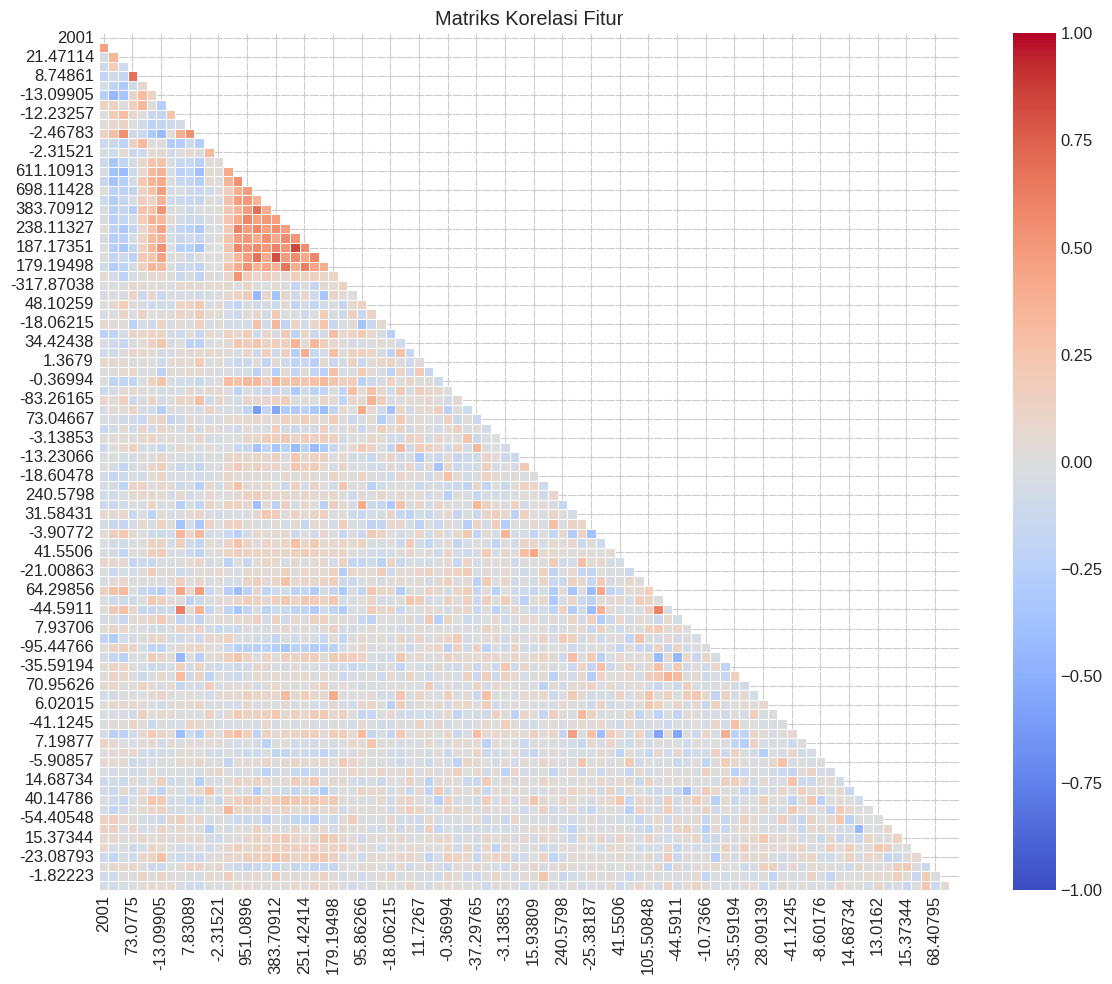

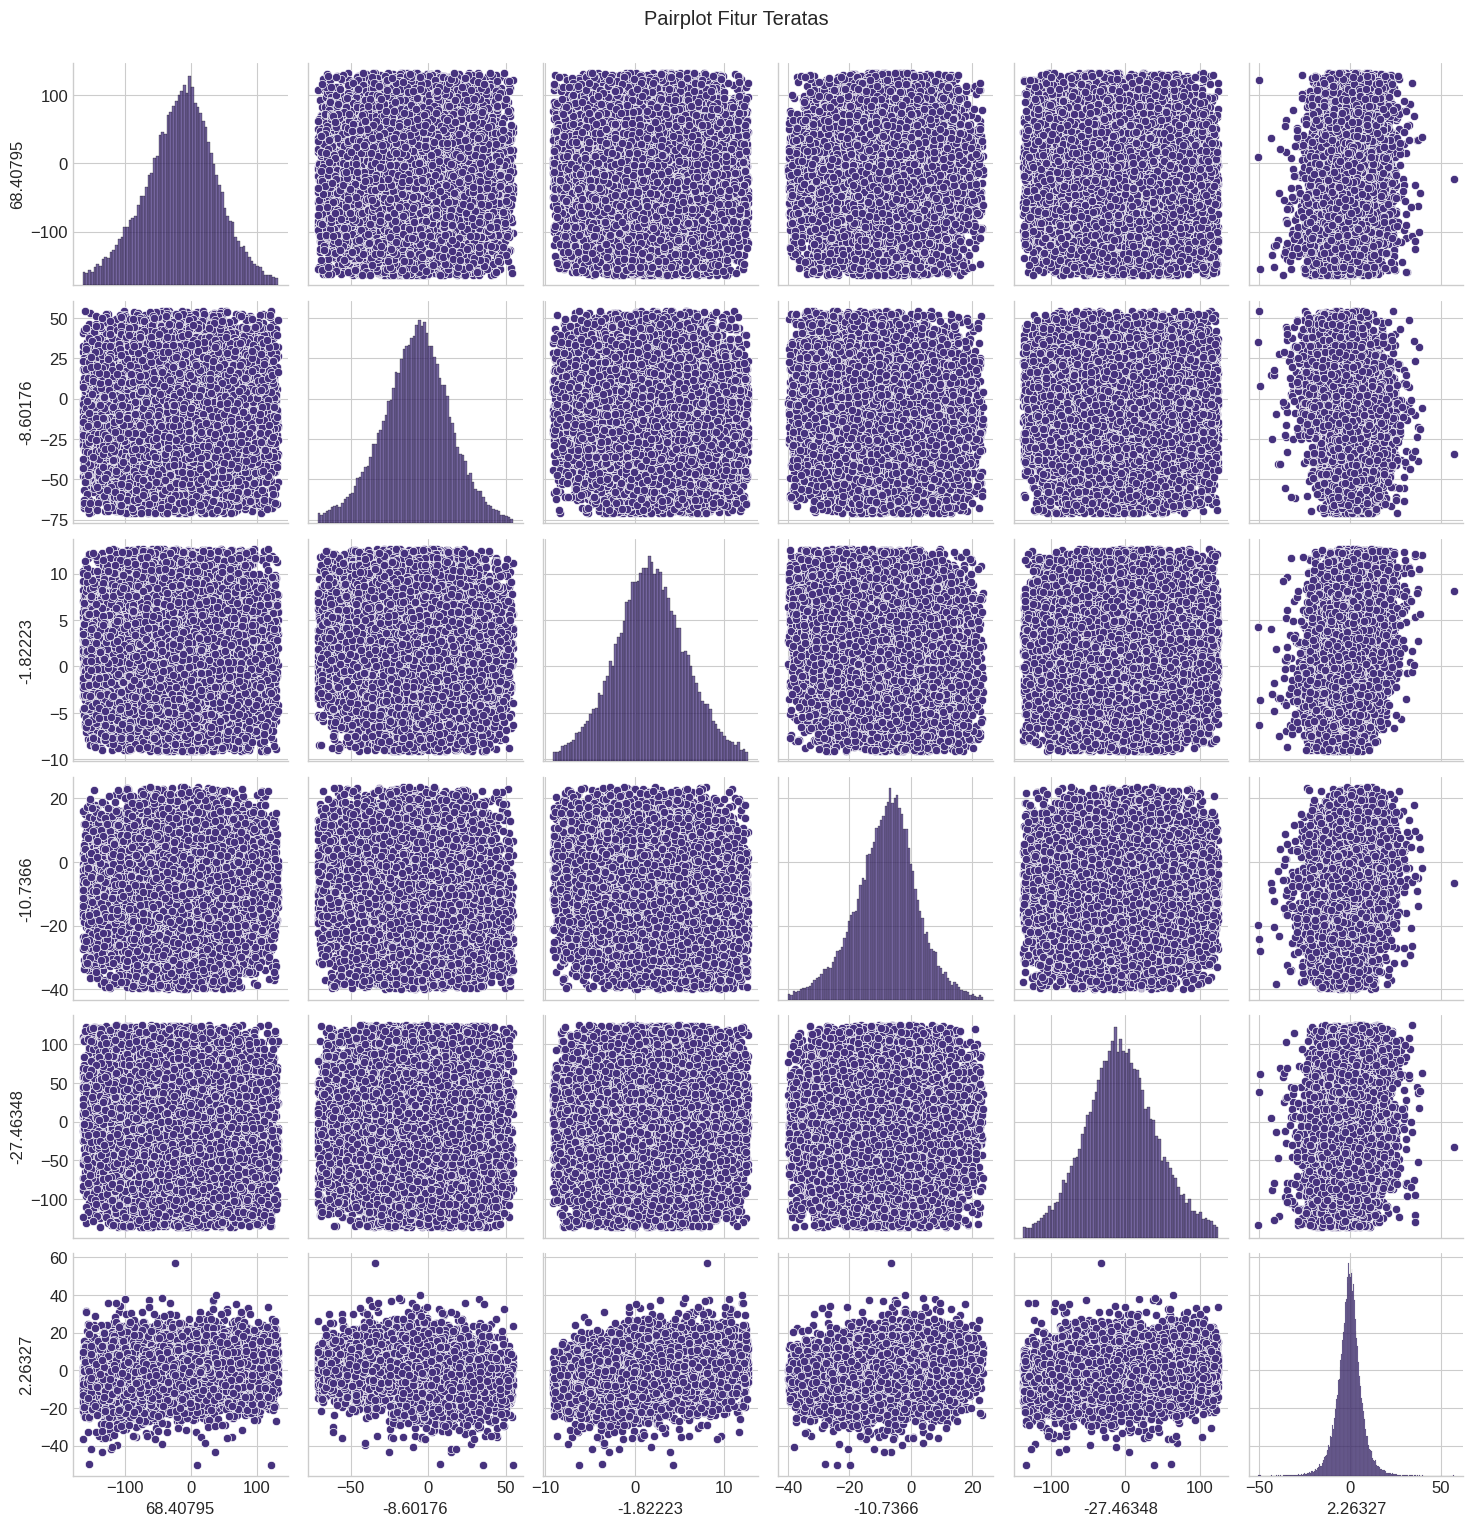

In [4]:
# Korelasi antar fitur
correlation_matrix = X.select_dtypes(include=['number']).corr()
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix))
sns.heatmap(correlation_matrix, mask=mask, annot=False,
           cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=0.5)
plt.title('Matriks Korelasi Fitur')
plt.tight_layout()
plt.show()

# Jika dataset tidak terlalu besar, tampilkan pairplot untuk beberapa fitur teratas
if len(X.columns) > 5:
    # Pilih beberapa fitur berdasarkan mutual information atau cara lain
    # tanpa menggunakan target_column dari correlation_matrix

    # Opsi 1: Pilih 5 fitur pertama saja (cara sederhana)
    top_features = X.columns[:5]

    # Opsi 2: Jika telah menghitung mutual information sebelumnya
    # top_features = mi_scores.nlargest(5).index

    # Opsi 3: Hitung korelasi antara setiap fitur dengan target
    corr_with_target = pd.DataFrame()
    for col in X.columns:
        corr_with_target.loc[col, 'correlation'] = X[col].corr(y)

    top_features = corr_with_target['correlation'].abs().nlargest(5).index

    # Buat pairplot dengan fitur yang dipilih
    sns.pairplot(pd.concat([X[top_features], pd.Series(y, name=target_column)], axis=1))
    plt.suptitle('Pairplot Fitur Teratas', y=1.02)
    plt.show()
else:
    sns.pairplot(pd.concat([X, pd.Series(y, name=target_column)], axis=1))
    plt.suptitle('Pairplot Dataset', y=1.02)
    plt.show()

## 2. Feature Selection

Feature selection adalah proses memilih fitur yang paling relevan untuk model. Kita akan menggunakan berbagai teknik termasuk menghapus fitur konstan/quasi-konstan, mendeteksi fitur duplikat, dan analisis korelasi.

In [5]:
print("\n" + "="*80)
print("LANGKAH 2: FEATURE SELECTION")
print("="*80)

# A. Menghapus fitur konstan dan quasi-konstan
print("\n" + "-"*50)
print("A. Mengidentifikasi Fitur Konstan dan Quasi-Konstan")
print("-"*50)

numeric_features = X.select_dtypes(include=['number']).columns.tolist()

if numeric_features:
    variance_selector = VarianceThreshold(threshold=0.01)  # Fitur dengan variance < 0.01 akan dihapus
    X_var = X[numeric_features]
    variance_selector.fit(X_var)

    # Identifikasi fitur dengan variance rendah
    constant_features = [feature for feature, variance in
                        zip(numeric_features, variance_selector.variances_) if variance <= 0.01]

    if constant_features:
        print(f"Fitur dengan variance rendah yang akan dihapus: {constant_features}")
        X = X.drop(columns=constant_features)
        numeric_features = [col for col in numeric_features if col not in constant_features]
    else:
        print("Tidak ditemukan fitur konstan atau quasi-konstan.")
else:
    print("Tidak ada fitur numerik untuk dianalisis.")


LANGKAH 2: FEATURE SELECTION

--------------------------------------------------
A. Mengidentifikasi Fitur Konstan dan Quasi-Konstan
--------------------------------------------------
Tidak ditemukan fitur konstan atau quasi-konstan.


### Identifikasi Fitur dengan Korelasi Tinggi

Fitur yang sangat berkorelasi bisa menyebabkan multikolinearitas dan redundansi. Kita akan mengidentifikasi dan menghapus fitur yang memiliki korelasi tinggi dengan fitur lain.

In [6]:
# B. Identifikasi fitur dengan korelasi tinggi
print("\n" + "-"*50)
print("B. Mengidentifikasi Fitur dengan Korelasi Tinggi")
print("-"*50)

if len(numeric_features) > 1:
    correlation_matrix = X[numeric_features].corr().abs()

    # Identifikasi pasangan fitur dengan korelasi di atas threshold
    high_corr_threshold = 0.9  # Korelasi > 0.9 dianggap tinggi
    upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    high_corr_pairs = [(correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
                       for i, j in zip(*np.where(upper_tri > high_corr_threshold))]

    if high_corr_pairs:
        print("Pasangan fitur dengan korelasi tinggi (>0.9):")
        for feat1, feat2, corr in high_corr_pairs:
            print(f"  {feat1} dan {feat2}: {corr:.4f}")

        # Pilih satu fitur dari setiap pasangan untuk dihapus
        to_drop = set()
        for feat1, feat2, _ in high_corr_pairs:
            # Strategi: hapus fitur kedua dari setiap pasangan
            to_drop.add(feat2)

        if to_drop:
            print(f"\nFitur yang akan dihapus karena korelasi tinggi: {list(to_drop)}")
            X = X.drop(columns=list(to_drop))
            numeric_features = [col for col in numeric_features if col not in to_drop]
    else:
        print("Tidak ditemukan fitur dengan korelasi tinggi (>0.9).")
else:
    print("Tidak cukup fitur numerik untuk analisis korelasi.")


--------------------------------------------------
B. Mengidentifikasi Fitur dengan Korelasi Tinggi
--------------------------------------------------
Tidak ditemukan fitur dengan korelasi tinggi (>0.9).


### Seleksi Fitur dengan Mutual Information

Mutual Information mengukur seberapa banyak informasi yang diberikan suatu fitur tentang target. Fitur dengan MI tinggi cenderung lebih penting dalam memprediksi target.


--------------------------------------------------
C. Seleksi Fitur dengan Mutual Information
--------------------------------------------------
Skor Mutual Information (ranking fitur):
10.20556     0.084450
68.40795     0.069193
179.19498    0.050500
611.10913    0.040029
-8.60176     0.032916
               ...   
240.5798     0.000000
1.3679       0.000000
11.7267      0.000000
-37.36684    0.000000
7.19877      0.000000
Length: 90, dtype: float64


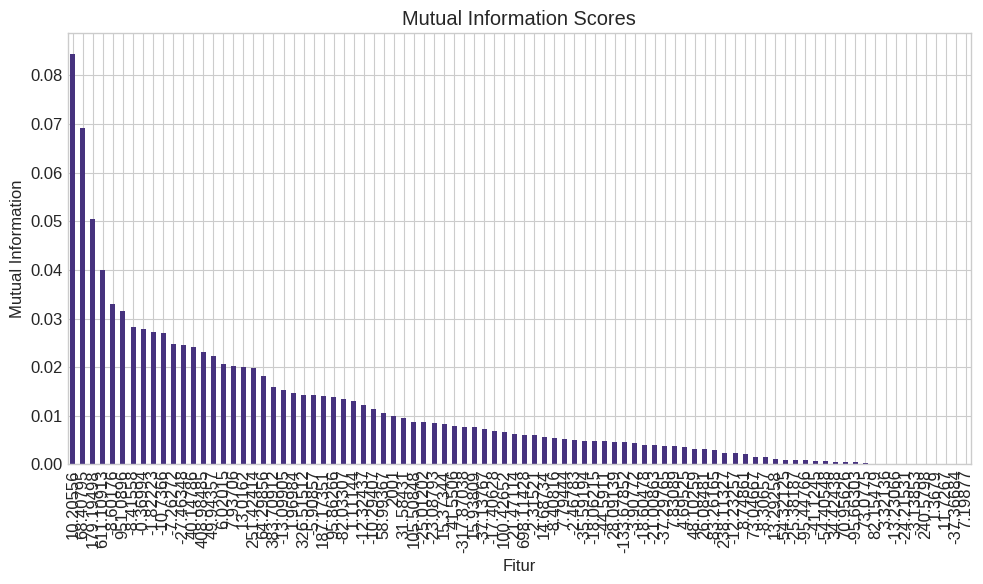


Fitur yang dipilih berdasarkan MI (>0.01): ['10.20556', '68.40795', '179.19498', '611.10913', '-8.60176', '951.0896', '-8.41558', '-0.36994', '-1.82223', '-10.7366', '-7.26272', '-27.46348', '40.14786', '408.98485', '49.94357', '6.02015', '7.93706', '13.0162', '251.42414', '64.29856', '383.70912', '-13.09905', '1.96984', '326.51512', '-5.90857', '187.17351', '95.86266', '-82.03307', '1.11144', '-12.32437', '-10.29407', '58.99367']
Fitur yang dihapus (MI rendah): ['2001', '21.47114', '73.0775', '8.74861', '-17.40628', '-25.01202', '-12.23257', '7.83089', '-2.46783', '3.32136', '-2.31521', '698.11428', '238.11327', '100.42652', '-317.87038', '48.10259', '-95.66303', '-18.06215', '34.42438', '11.7267', '1.3679', '7.79444', '-133.67852', '-83.26165', '-37.29765', '73.04667', '-37.36684', '-3.13853', '-24.21531', '-13.23066', '15.93809', '-18.60478', '82.15479', '240.5798', '31.58431', '-25.38187', '-3.90772', '13.29258', '41.5506', '-21.00863', '105.50848', '26.08481', '-44.5911', '-8.306

In [7]:
# C. Seleksi fitur dengan Mutual Information
print("\n" + "-"*50)
print("C. Seleksi Fitur dengan Mutual Information")
print("-"*50)

if len(numeric_features) > 0:
    # Hitung skor mutual information
    mi_scores = mutual_info_regression(X[numeric_features], y)
    mi_scores = pd.Series(mi_scores, index=numeric_features)
    mi_scores = mi_scores.sort_values(ascending=False)

    print("Skor Mutual Information (ranking fitur):")
    print(mi_scores)

    # Visualisasi skor MI
    plt.figure(figsize=(10, 6))
    mi_scores.plot.bar()
    plt.title('Mutual Information Scores')
    plt.ylabel('Mutual Information')
    plt.xlabel('Fitur')
    plt.tight_layout()
    plt.show()

    # Pilih fitur dengan MI di atas threshold
    mi_threshold = 0.01
    selected_features_mi = mi_scores[mi_scores > mi_threshold].index.tolist()

    if len(selected_features_mi) < len(numeric_features):
        print(f"\nFitur yang dipilih berdasarkan MI (>{mi_threshold}): {selected_features_mi}")

        # Fitur yang dihapus
        dropped_features_mi = [f for f in numeric_features if f not in selected_features_mi]
        print(f"Fitur yang dihapus (MI rendah): {dropped_features_mi}")

        # Update fitur yang dipertahankan
        X = X[selected_features_mi + [col for col in X.columns if col not in numeric_features]]
    else:
        print("Semua fitur numerik memiliki skor MI yang memadai.")
else:
    print("Tidak ada fitur numerik untuk analisis mutual information.")

### Seleksi Fitur dengan F-regression

F-regression mengukur korelasi linear antara fitur dan target. F-test menguji apakah koefisien regresi berbeda secara signifikan dari nol.


--------------------------------------------------
D. Seleksi Fitur dengan F-regression
--------------------------------------------------
Skor F-regression:
        Fitur      F_Score        P_Value
1    68.40795  3142.662180   0.000000e+00
4    -8.60176  1900.981809   0.000000e+00
8    -1.82223  1475.177837  8.509643e-317
9    -10.7366  1455.146720  1.331373e-312
11  -27.46348  1090.295557  7.894031e-236
16    7.93706   775.183044  6.171937e-169
12   40.14786   626.754974  3.124977e-137
28    1.11144   576.032836  2.285647e-126
2   179.19498   382.360101   9.759296e-85
10   -7.26272   330.384070   1.601343e-73
7    -0.36994   327.981188   5.289799e-73
13  408.98485   292.391548   2.599962e-65
24   -5.90857   275.978882   9.234272e-62
25  187.17351   258.354937   6.030686e-58
20  383.70912   219.537453   1.558718e-49
6    -8.41558   218.583644   2.509888e-49
5    951.0896   167.982532   2.451502e-38
29  -12.32437   161.603388   5.984993e-37
0    10.20556   150.734096   1.389044e-34
2

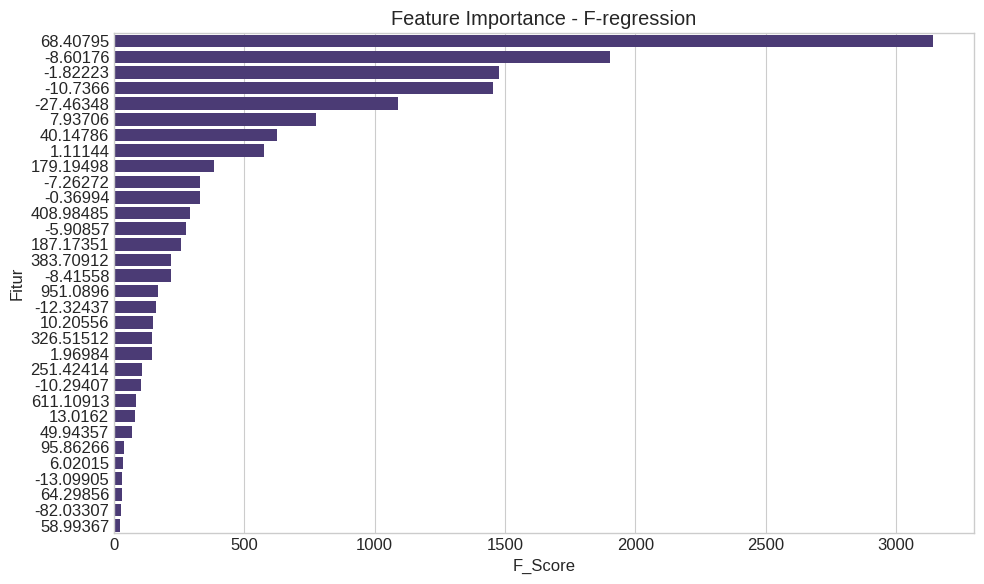

Semua fitur numerik signifikan secara statistik.

--------------------------------------------------
Ringkasan Feature Selection
--------------------------------------------------
Fitur awal: 90
Fitur setelah seleksi: 32
Fitur yang dipertahankan: ['10.20556', '68.40795', '179.19498', '611.10913', '-8.60176', '951.0896', '-8.41558', '-0.36994', '-1.82223', '-10.7366', '-7.26272', '-27.46348', '40.14786', '408.98485', '49.94357', '6.02015', '7.93706', '13.0162', '251.42414', '64.29856', '383.70912', '-13.09905', '1.96984', '326.51512', '-5.90857', '187.17351', '95.86266', '-82.03307', '1.11144', '-12.32437', '-10.29407', '58.99367']


In [8]:
# D. Seleksi fitur dengan f_regression (untuk regresi)
print("\n" + "-"*50)
print("D. Seleksi Fitur dengan F-regression")
print("-"*50)

numeric_features = X.select_dtypes(include=['number']).columns.tolist()

if len(numeric_features) > 0:
    # Gunakan f_regression untuk fitur numerik terhadap target
    f_selector = SelectKBest(f_regression, k='all')
    f_selector.fit(X[numeric_features], y)

    # Dapatkan skor dan p-values
    f_scores = pd.DataFrame({
        'Fitur': numeric_features,
        'F_Score': f_selector.scores_,
        'P_Value': f_selector.pvalues_
    }).sort_values('F_Score', ascending=False)

    print("Skor F-regression:")
    print(f_scores)

    # Visualisasi F-scores
    plt.figure(figsize=(10, 6))
    sns.barplot(x='F_Score', y='Fitur', data=f_scores)
    plt.title('Feature Importance - F-regression')
    plt.tight_layout()
    plt.show()

    # Pilih fitur signifikan (p-value < 0.05)
    significant_features = f_scores[f_scores['P_Value'] < 0.05]['Fitur'].tolist()

    if len(significant_features) < len(numeric_features):
        print(f"\nFitur signifikan (p-value < 0.05): {significant_features}")

        # Fitur yang dihapus
        dropped_features_f = [f for f in numeric_features if f not in significant_features]
        print(f"Fitur yang dihapus (tidak signifikan): {dropped_features_f}")

        # Update fitur yang dipertahankan (pastikan untuk mempertahankan fitur kategorikal jika ada)
        X = X[significant_features + [col for col in X.columns if col not in numeric_features]]
    else:
        print("Semua fitur numerik signifikan secara statistik.")
else:
    print("Tidak ada fitur numerik untuk analisis F-regression.")

# Ringkasan fitur terpilih
print("\n" + "-"*50)
print("Ringkasan Feature Selection")
print("-"*50)

print(f"Fitur awal: {df.drop(columns=[target_column]).shape[1]}")
print(f"Fitur setelah seleksi: {X.shape[1]}")
print("Fitur yang dipertahankan:", X.columns.tolist())

## 3. Feature Engineering

Feature engineering adalah proses menciptakan fitur baru dari fitur yang ada atau mentransformasi fitur untuk meningkatkan performa model.


LANGKAH 3: FEATURE ENGINEERING

--------------------------------------------------
A. Transformasi Data
--------------------------------------------------


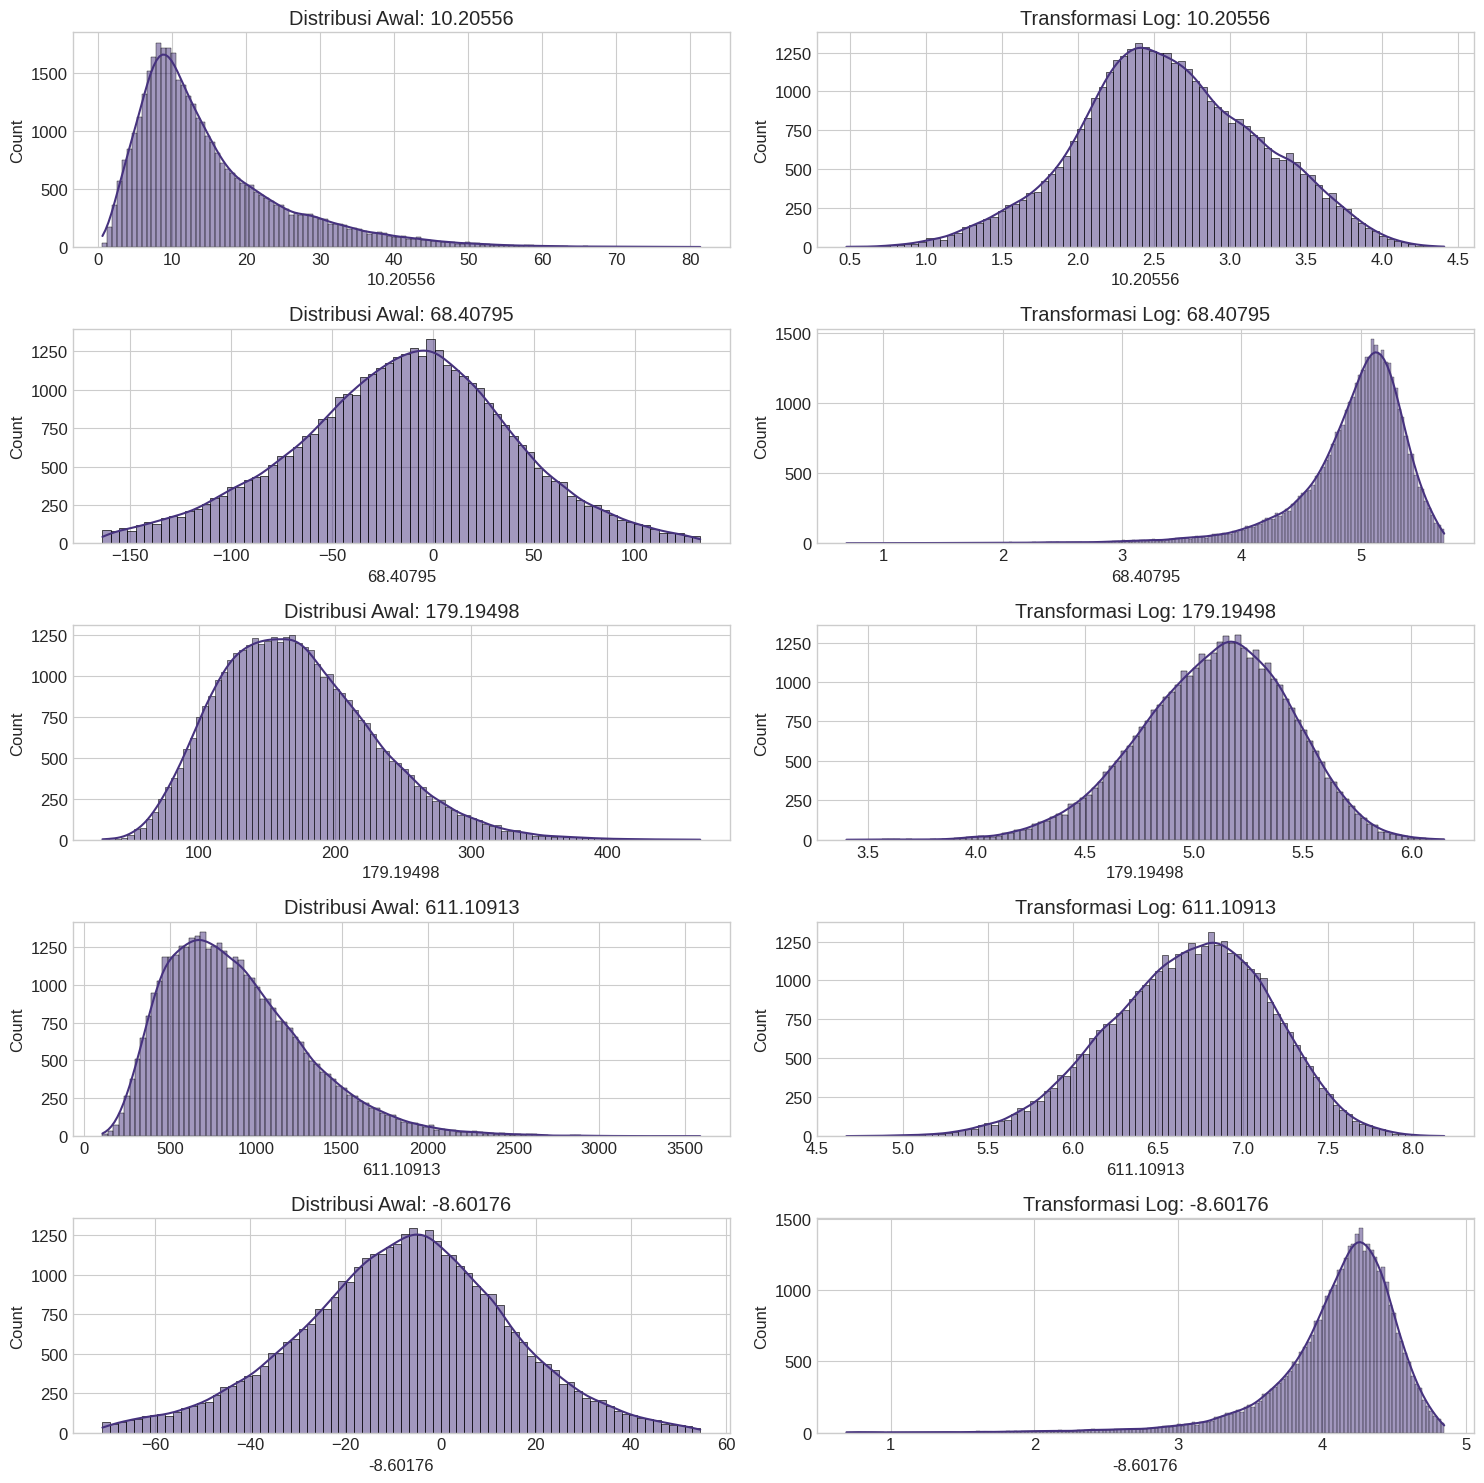

Transformasi power (Yeo-Johnson) diterapkan pada fitur numerik.


In [9]:
print("\n" + "="*80)
print("LANGKAH 3: FEATURE ENGINEERING")
print("="*80)

# Feature Engineering
print("\n" + "-"*50)
print("A. Transformasi Data")
print("-"*50)

# A. Transformasi untuk distribusi yang lebih normal
numeric_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Visualisasi distribusi awal fitur numerik
if len(numeric_features) > 0:
    n_features = min(len(numeric_features), 5)  # Tampilkan maksimal 5 fitur
    plt.figure(figsize=(15, 3*n_features))

    for i, feature in enumerate(numeric_features[:n_features]):
        plt.subplot(n_features, 2, 2*i+1)
        sns.histplot(X[feature], kde=True)
        plt.title(f'Distribusi Awal: {feature}')

        # Coba transformasi log(x+1) sebagai contoh
        plt.subplot(n_features, 2, 2*i+2)
        transformed = np.log1p(X[feature] - X[feature].min() + 1) if X[feature].min() < 0 else np.log1p(X[feature])
        sns.histplot(transformed, kde=True)
        plt.title(f'Transformasi Log: {feature}')

    plt.tight_layout()
    plt.show()

# Untuk fitur yang sangat skewed, terapkan power transformation
if len(numeric_features) > 0:
    try:
        pt = PowerTransformer(method='yeo-johnson')
        X_transformed = pd.DataFrame(
            pt.fit_transform(X[numeric_features]),
            columns=numeric_features,
            index=X.index
        )

        # Ganti nilai numerik dengan versi yang ditransformasi
        X[numeric_features] = X_transformed

        print("Transformasi power (Yeo-Johnson) diterapkan pada fitur numerik.")
    except Exception as e:
        print(f"Error saat menerapkan power transformation: {e}")
        print("Melanjutkan tanpa transformasi.")

### Feature Encoding dan Scaling

Pada langkah ini, kita akan melakukan encoding untuk fitur kategorikal (jika ada) dan menskalakan semua fitur untuk memastikan semua fitur memiliki skala yang sama.

In [10]:
# B. Feature Encoding (jika ada fitur kategorikal)
print("\n" + "-"*50)
print("B. Feature Encoding")
print("-"*50)

if len(categorical_features) > 0:
    print(f"Fitur kategorikal yang akan diencoding: {categorical_features}")

    # One-hot encoding untuk fitur kategorikal
    X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

    print(f"Jumlah fitur setelah one-hot encoding: {X.shape[1]}")
else:
    print("Tidak ada fitur kategorikal untuk diencoding.")

# C. Scaling/Normalisasi Fitur
print("\n" + "-"*50)
print("C. Scaling Fitur")
print("-"*50)

# StandardScaler menyesuaikan fitur menjadi mean=0 dan variance=1
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print("StandardScaler diterapkan pada semua fitur.")
print("\nStatistik setelah scaling:")
print(X_scaled.describe().T[['mean', 'std', 'min', 'max']].head())


--------------------------------------------------
B. Feature Encoding
--------------------------------------------------
Tidak ada fitur kategorikal untuk diencoding.

--------------------------------------------------
C. Scaling Fitur
--------------------------------------------------
StandardScaler diterapkan pada semua fitur.

Statistik setelah scaling:
                   mean       std       min       max
10.20556  -2.049519e-17  1.000013 -3.559253  3.021201
68.40795  -2.195914e-18  1.000013 -2.644596  2.876136
179.19498  4.391827e-18  1.000013 -3.877083  3.646030
611.10913  2.781491e-17  1.000013 -3.535952  3.727224
-8.60176   1.537140e-17  1.000013 -2.806702  2.962367


### Feature Interaction

Interaksi antar fitur dapat meningkatkan kemampuan model untuk menangkap hubungan kompleks dalam data. Kita akan mencoba membuat beberapa fitur interaksi.


--------------------------------------------------
D. Feature Interaction
--------------------------------------------------
Membuat fitur interaksi...
Dibuat fitur interaksi: 10.20556_x_68.40795


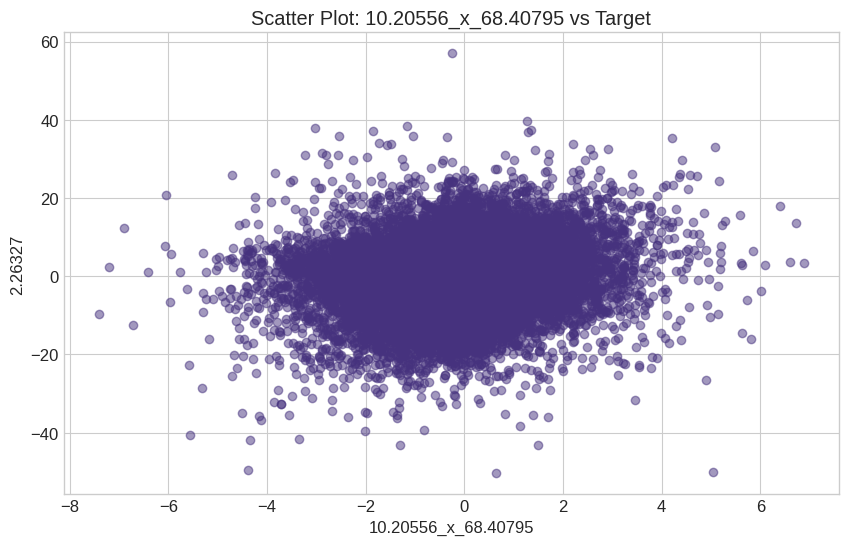

In [11]:
# D. Feature Creation/Interaction (opsional)
print("\n" + "-"*50)
print("D. Feature Interaction")
print("-"*50)

if len(numeric_features) >= 2:
    # Buat beberapa fitur interaksi sebagai contoh
    print("Membuat fitur interaksi...")

    # Pilih 2 fitur teratas berdasarkan mutual information (jika tersedia)
    top_features = numeric_features[:2]
    if len(top_features) == 2:
        interaction_name = f"{top_features[0]}_x_{top_features[1]}"
        X_scaled[interaction_name] = X_scaled[top_features[0]] * X_scaled[top_features[1]]
        print(f"Dibuat fitur interaksi: {interaction_name}")

        # Visualisasikan pengaruh fitur interaksi terhadap target
        plt.figure(figsize=(10, 6))
        plt.scatter(X_scaled[interaction_name], y, alpha=0.5)
        plt.title(f'Scatter Plot: {interaction_name} vs Target')
        plt.xlabel(interaction_name)
        plt.ylabel(target_column)
        plt.grid(True)
        plt.show()
else:
    print("Tidak cukup fitur numerik untuk membuat interaksi.")

## 4. Model Training dan Evaluasi

Pada langkah ini, kita akan melatih dan mengevaluasi berbagai model regresi untuk memprediksi variabel target.

In [12]:
print("\n" + "="*80)
print("LANGKAH 4: MODEL TRAINING DAN EVALUASI")
print("="*80)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

print(f"Ukuran data training: {X_train.shape}, {y_train.shape}")
print(f"Ukuran data testing: {X_test.shape}, {y_test.shape}")

# Definisikan model-model untuk dilatih dan dievaluasi
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Polynomial Regression (degree=2)': make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False),
        LinearRegression()
    ),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    'SVR': SVR(kernel='rbf', C=1.0, gamma='scale', epsilon=0.05),
    # Gunakan estimator bukan base_estimator
    'Bagging Regressor': BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=5),
        n_estimators=10,
        random_state=42
    ),
    'AdaBoost Regressor': AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=3),  # Ubah ini juga jika perlu
        n_estimators=50,
        random_state=42
    ),
    'Gradient Boosting Regressor': GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
}


LANGKAH 4: MODEL TRAINING DAN EVALUASI
Ukuran data training: (31063, 33), (31063,)
Ukuran data testing: (7766, 33), (7766,)


### Fungsi Evaluasi Model

Kita mendefinisikan fungsi untuk mengevaluasi dan memvisualisasikan performa model. Untuk setiap model, kita akan menampilkan berbagai metrik performa dan visualisasi nilai aktual vs prediksi.

In [13]:
# Fungsi untuk mengevaluasi dan visualisasi model
def evaluate_and_visualize(name, model, X_train, X_test, y_train, y_test):
    # Latih model
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Buat prediksi
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Hitung metrik evaluasi
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    try:
        test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
    except:
        test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    test_explained_var = explained_variance_score(y_test, y_pred_test)

    # Tampilkan hasil evaluasi
    print(f"\n{'-'*50}")
    print(f"Evaluasi Model: {name}")
    print(f"{'-'*50}")
    print(f"Training time: {training_time:.4f} detik")
    print("\nMetrik Kinerja pada Data Training:")
    print(f"MSE: {train_mse:.4f}")
    print(f"RMSE: {train_rmse:.4f}")
    print(f"R²: {train_r2:.4f}")

    print("\nMetrik Kinerja pada Data Testing:")
    print(f"MSE: {test_mse:.4f}")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print(f"MAPE: {test_mape:.4f}%")
    print(f"R²: {test_r2:.4f}")
    print(f"Explained Variance: {test_explained_var:.4f}")

    # Visualisasi aktual vs prediksi
    plt.figure(figsize=(12, 5))

    # Training
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_pred_train, alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    plt.title(f'{name} - Training Data')
    plt.xlabel('Nilai Aktual')
    plt.ylabel('Nilai Prediksi')
    plt.grid(True)

    # Testing
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'{name} - Testing Data')
    plt.xlabel('Nilai Aktual')
    plt.ylabel('Nilai Prediksi')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Visualisasi residual
    plt.figure(figsize=(12, 5))

   # Residual plot
    plt.subplot(1, 2, 1)
    residuals = y_test - y_pred_test
    plt.scatter(y_pred_test, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'{name} - Residual Plot')
    plt.xlabel('Nilai Prediksi')
    plt.ylabel('Residual')
    plt.grid(True)

    # Distribusi residual
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f'{name} - Distribusi Residual')
    plt.xlabel('Residual')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        'Model': name,
        'MSE': test_mse,
        'RMSE': test_rmse,
        'MAE': test_mae,
        'MAPE': test_mape,
        'R²': test_r2,
        'Explained Variance': test_explained_var,
        'Training Time': training_time
    }

### Pelatihan dan Evaluasi Model

Sekarang kita akan melatih dan mengevaluasi semua model yang telah kita definisikan.


Melatih dan mengevaluasi model: Linear Regression

--------------------------------------------------
Evaluasi Model: Linear Regression
--------------------------------------------------
Training time: 0.0566 detik

Metrik Kinerja pada Data Training:
MSE: 33.1250
RMSE: 5.7554
R²: 0.2920

Metrik Kinerja pada Data Testing:
MSE: 32.7341
RMSE: 5.7214
MAE: 4.0652
MAPE: 2.8763%
R²: 0.2954
Explained Variance: 0.2954


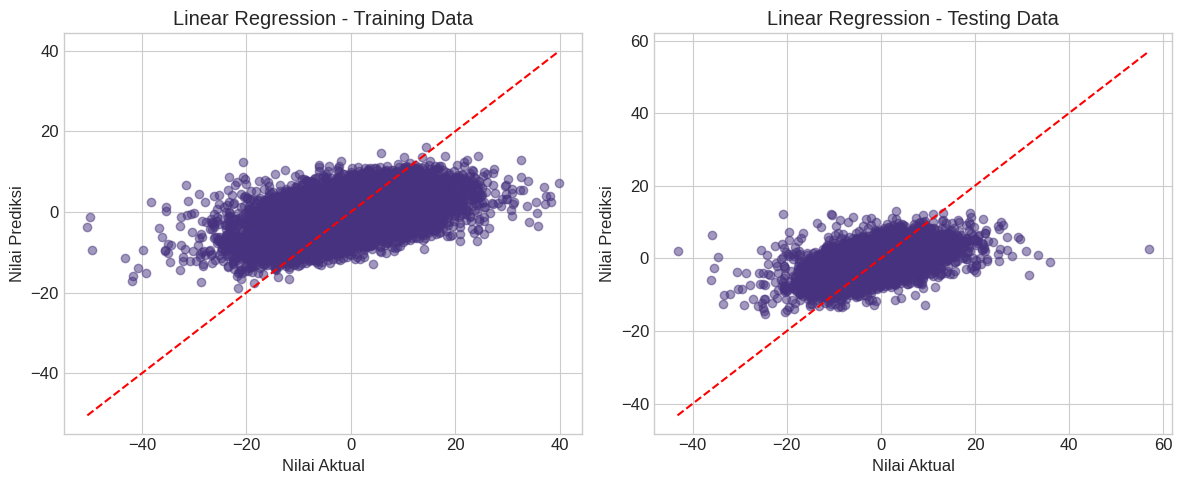

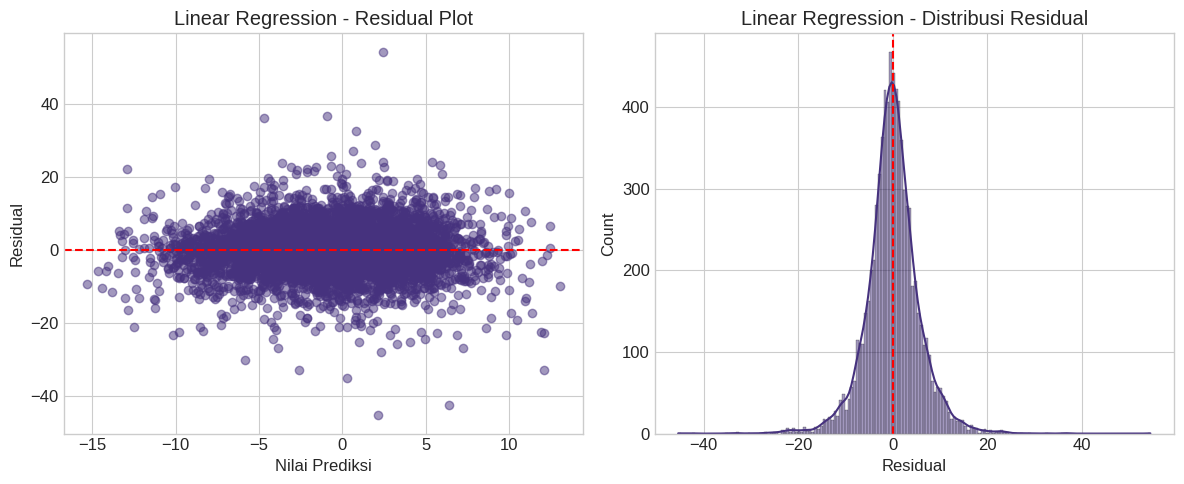


Melatih dan mengevaluasi model: Ridge Regression

--------------------------------------------------
Evaluasi Model: Ridge Regression
--------------------------------------------------
Training time: 0.0219 detik

Metrik Kinerja pada Data Training:
MSE: 33.1250
RMSE: 5.7554
R²: 0.2920

Metrik Kinerja pada Data Testing:
MSE: 32.7341
RMSE: 5.7214
MAE: 4.0652
MAPE: 2.8763%
R²: 0.2954
Explained Variance: 0.2954


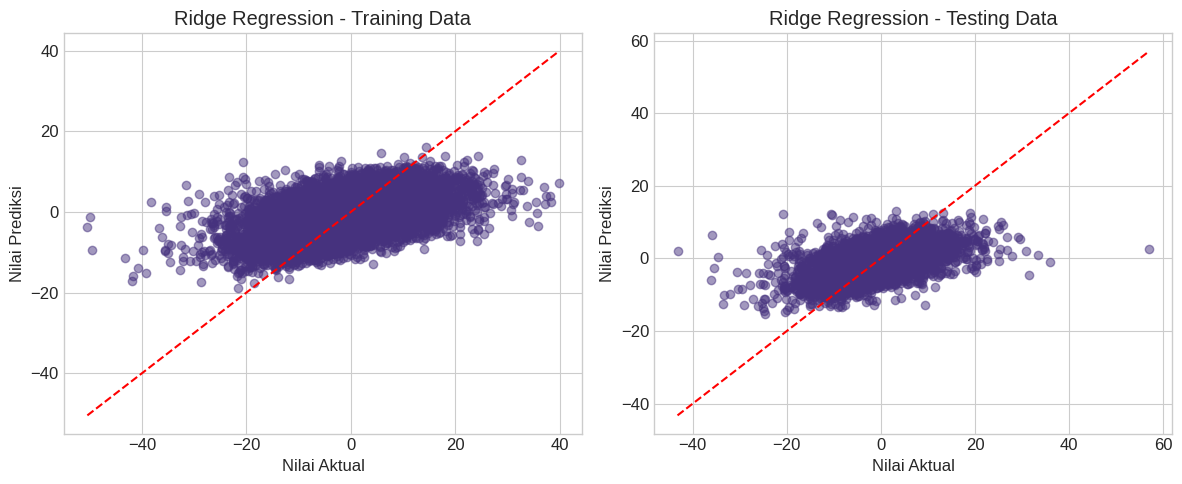

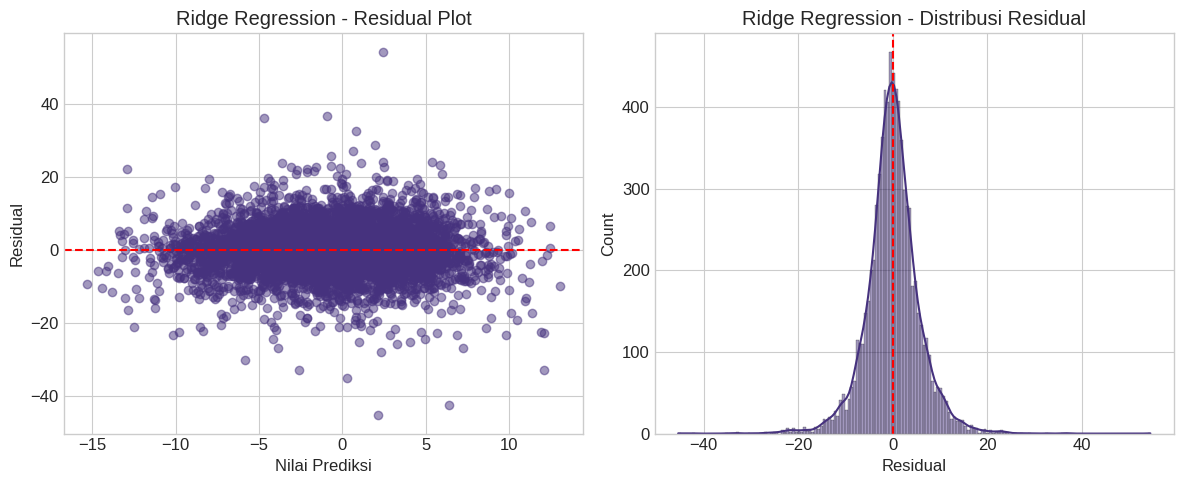


Melatih dan mengevaluasi model: Polynomial Regression (degree=2)

--------------------------------------------------
Evaluasi Model: Polynomial Regression (degree=2)
--------------------------------------------------
Training time: 2.4089 detik

Metrik Kinerja pada Data Training:
MSE: 21.2249
RMSE: 4.6070
R²: 0.5463

Metrik Kinerja pada Data Testing:
MSE: 23.0248
RMSE: 4.7984
MAE: 3.3965
MAPE: 2.7126%
R²: 0.5044
Explained Variance: 0.5045


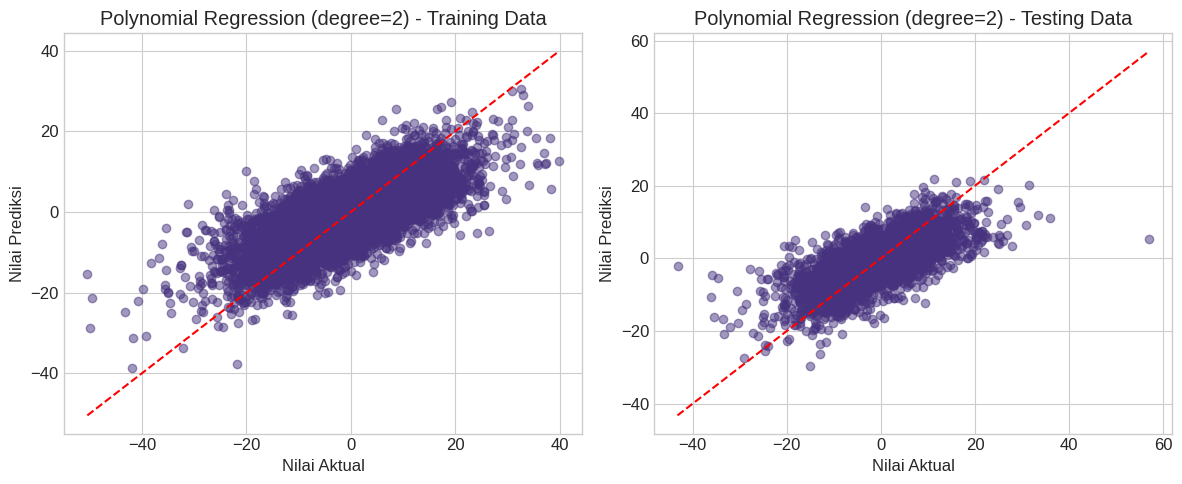

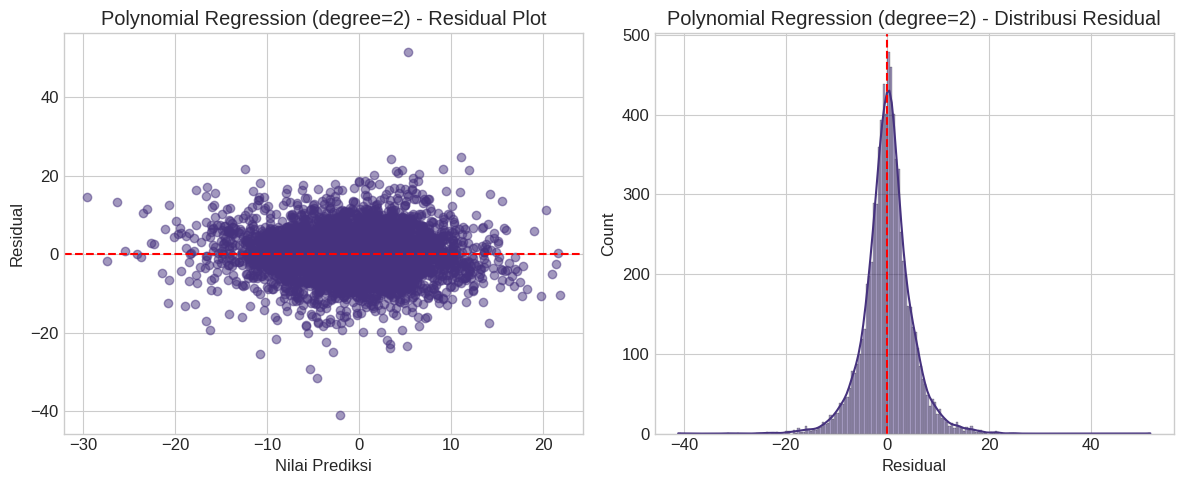


Melatih dan mengevaluasi model: Decision Tree

--------------------------------------------------
Evaluasi Model: Decision Tree
--------------------------------------------------
Training time: 0.9730 detik

Metrik Kinerja pada Data Training:
MSE: 34.1820
RMSE: 5.8465
R²: 0.2694

Metrik Kinerja pada Data Testing:
MSE: 35.5584
RMSE: 5.9631
MAE: 4.3307
MAPE: 3.0424%
R²: 0.2346
Explained Variance: 0.2346


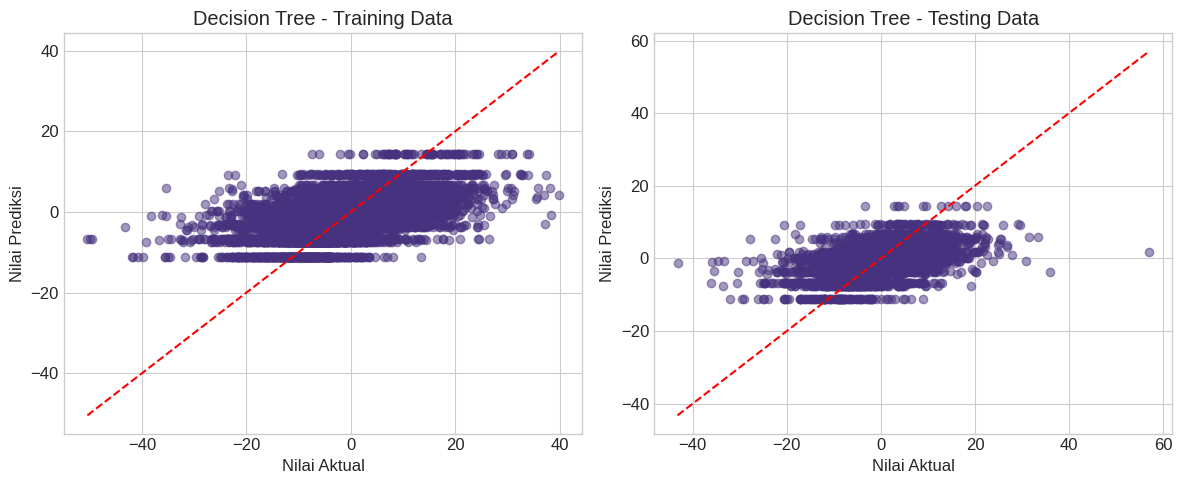

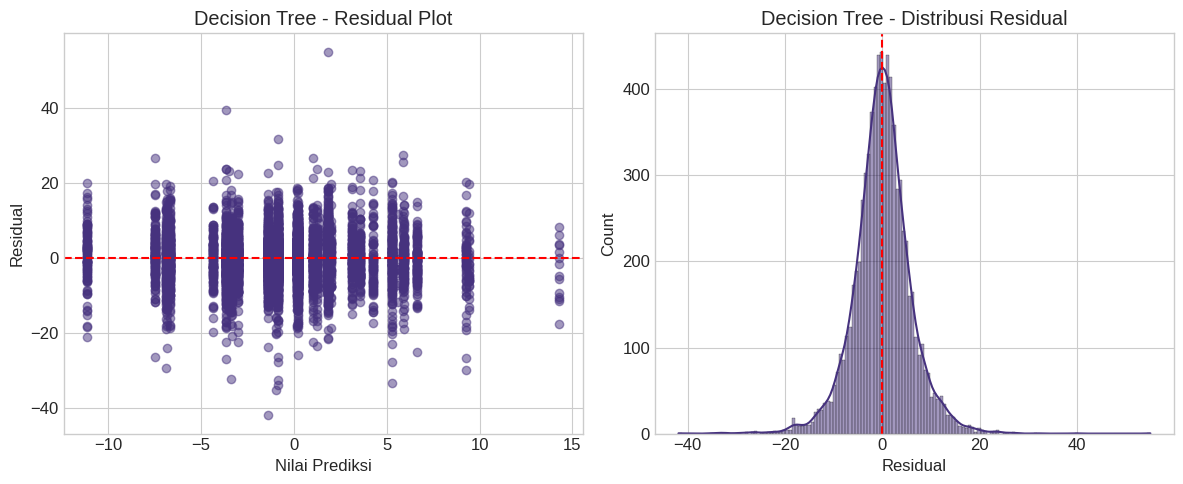


Melatih dan mengevaluasi model: K-Nearest Neighbors

--------------------------------------------------
Evaluasi Model: K-Nearest Neighbors
--------------------------------------------------
Training time: 0.0329 detik

Metrik Kinerja pada Data Training:
MSE: 21.3327
RMSE: 4.6187
R²: 0.5440

Metrik Kinerja pada Data Testing:
MSE: 32.9246
RMSE: 5.7380
MAE: 4.1284
MAPE: 2.8047%
R²: 0.2913
Explained Variance: 0.2914


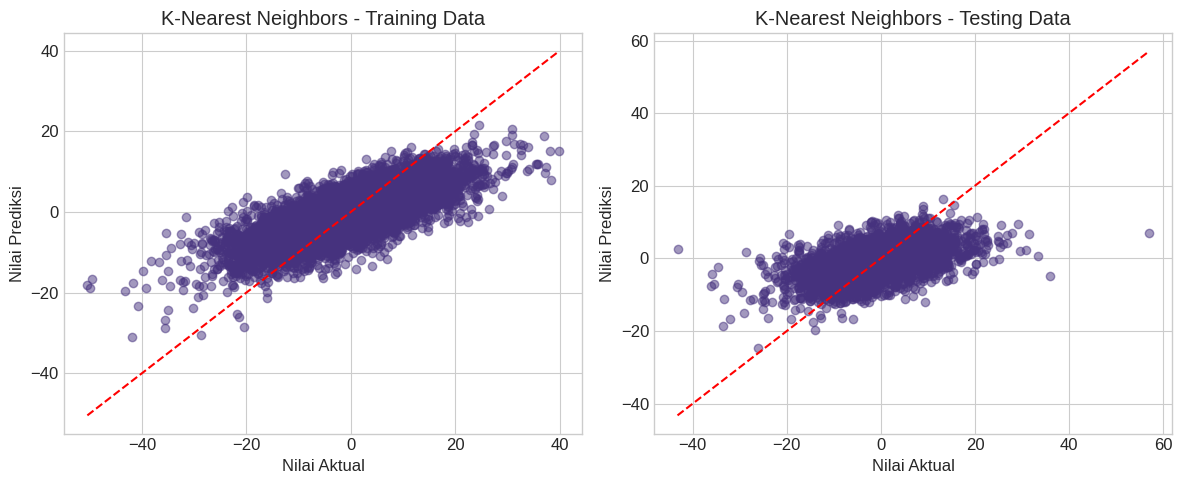

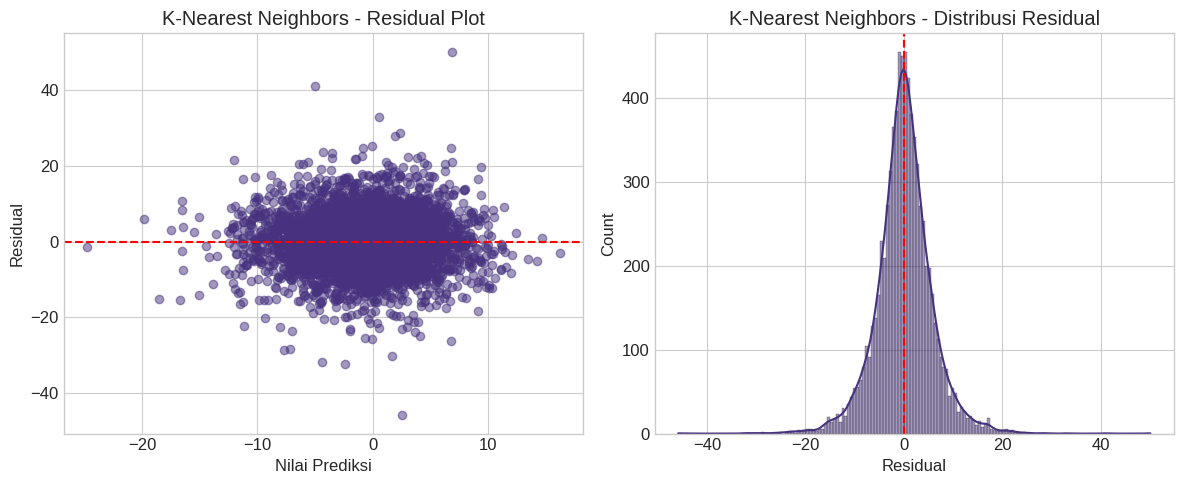


Melatih dan mengevaluasi model: SVR

--------------------------------------------------
Evaluasi Model: SVR
--------------------------------------------------
Training time: 80.0207 detik

Metrik Kinerja pada Data Training:
MSE: 22.0287
RMSE: 4.6935
R²: 0.5292

Metrik Kinerja pada Data Testing:
MSE: 24.3913
RMSE: 4.9388
MAE: 3.4211
MAPE: 2.6443%
R²: 0.4750
Explained Variance: 0.4750


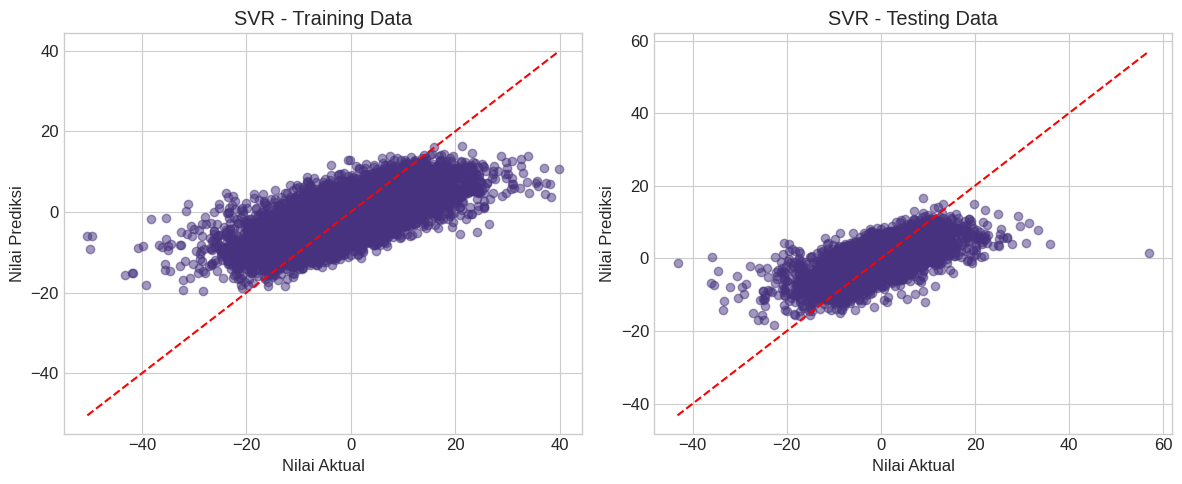

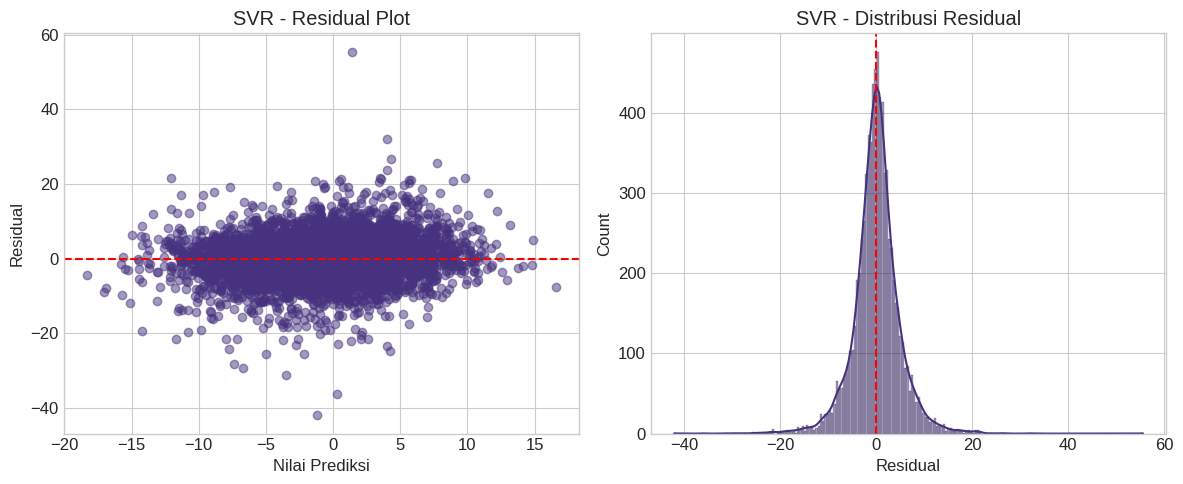


Melatih dan mengevaluasi model: Bagging Regressor

--------------------------------------------------
Evaluasi Model: Bagging Regressor
--------------------------------------------------
Training time: 6.7581 detik

Metrik Kinerja pada Data Training:
MSE: 32.1828
RMSE: 5.6730
R²: 0.3121

Metrik Kinerja pada Data Testing:
MSE: 33.4136
RMSE: 5.7804
MAE: 4.1581
MAPE: 2.6193%
R²: 0.2808
Explained Variance: 0.2808


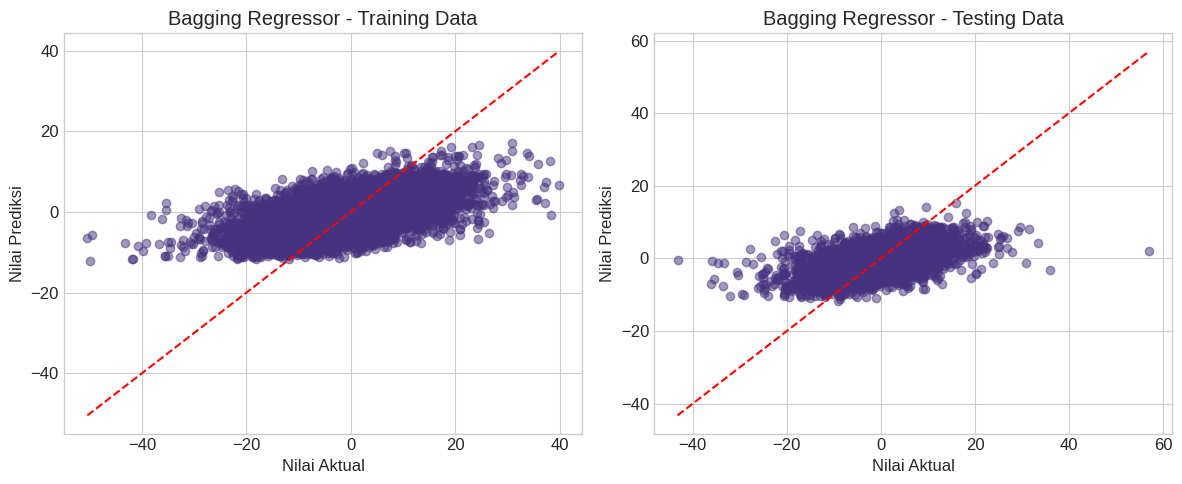

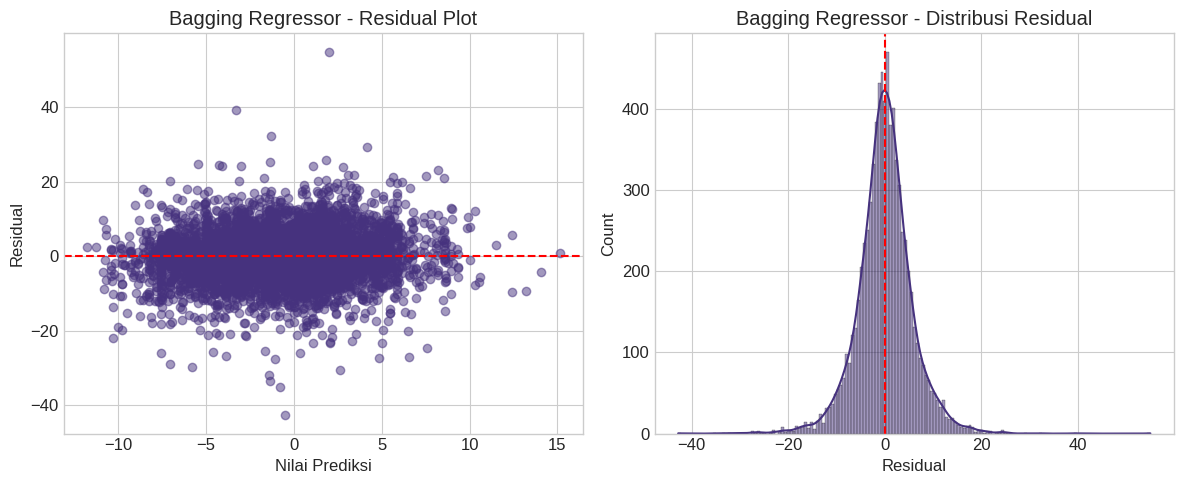


Melatih dan mengevaluasi model: AdaBoost Regressor

--------------------------------------------------
Evaluasi Model: AdaBoost Regressor
--------------------------------------------------
Training time: 13.0854 detik

Metrik Kinerja pada Data Training:
MSE: 33.4910
RMSE: 5.7871
R²: 0.2842

Metrik Kinerja pada Data Testing:
MSE: 34.3928
RMSE: 5.8645
MAE: 4.3347
MAPE: 2.1070%
R²: 0.2597
Explained Variance: 0.2631


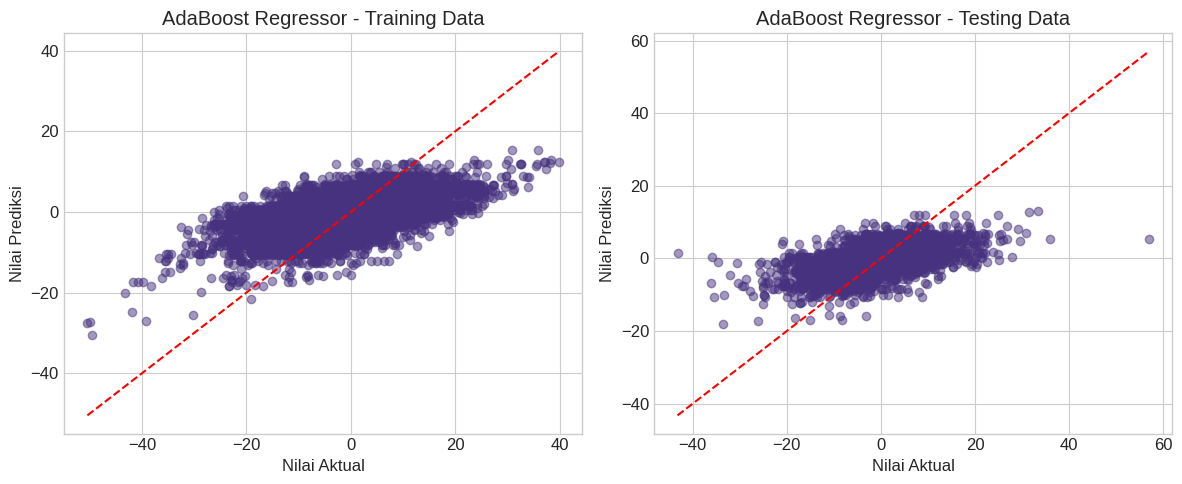

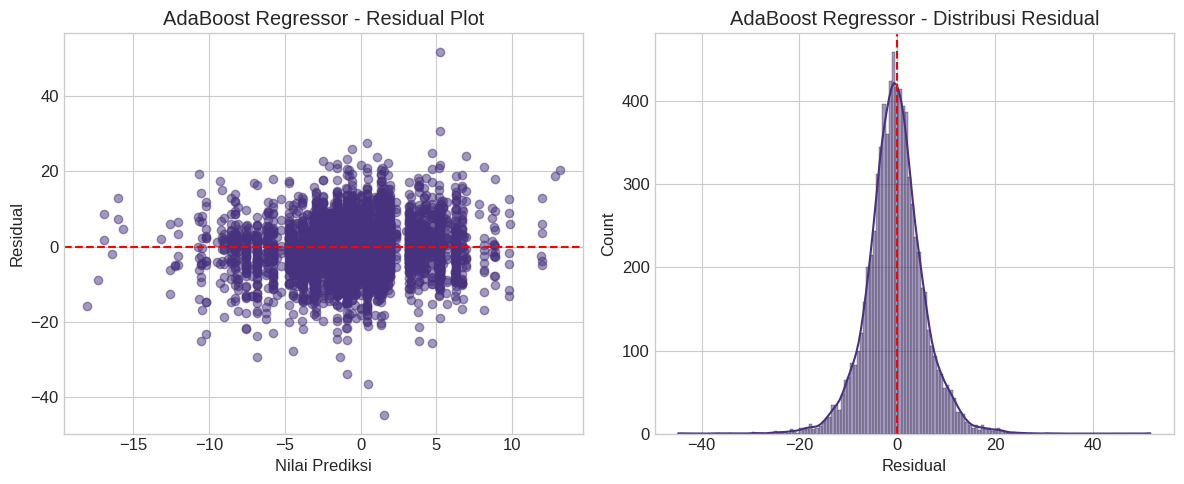


Melatih dan mengevaluasi model: Gradient Boosting Regressor

--------------------------------------------------
Evaluasi Model: Gradient Boosting Regressor
--------------------------------------------------
Training time: 64.3083 detik

Metrik Kinerja pada Data Training:
MSE: 24.0020
RMSE: 4.8992
R²: 0.4870

Metrik Kinerja pada Data Testing:
MSE: 26.1057
RMSE: 5.1094
MAE: 3.6211
MAPE: 2.6468%
R²: 0.4381
Explained Variance: 0.4381


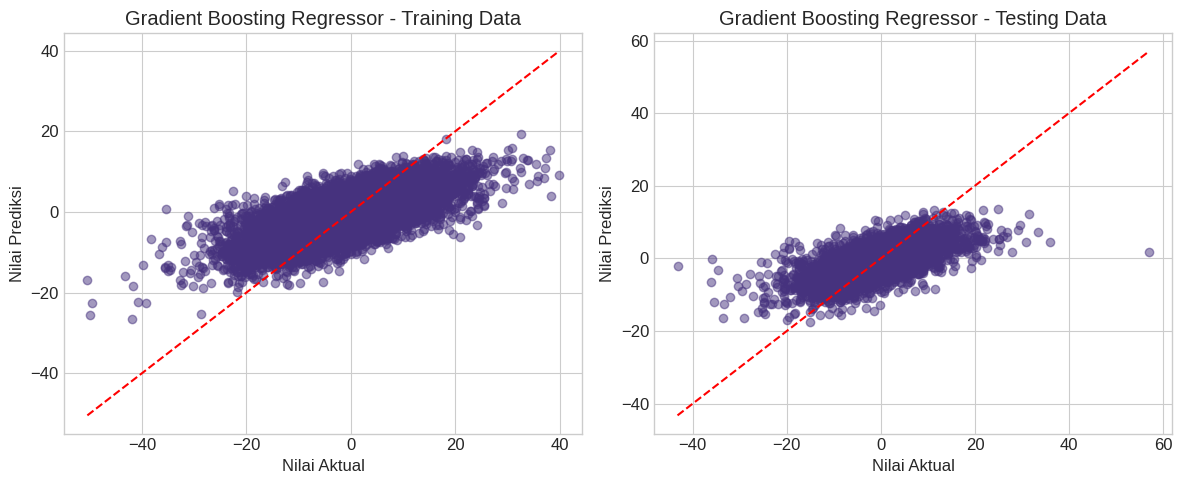

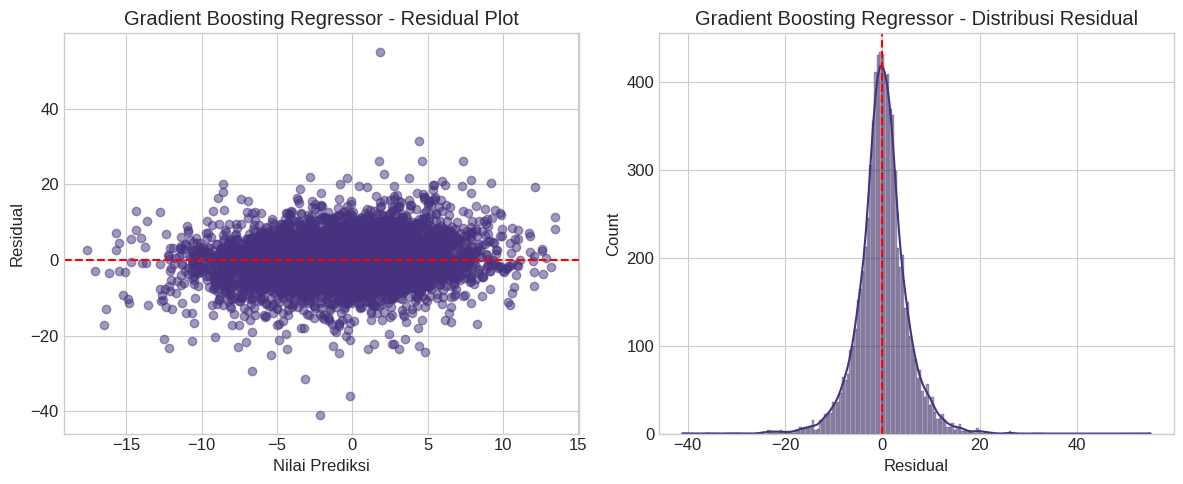

In [14]:
# Latih dan evaluasi semua model
results = []
for name, model in models.items():
    print(f"\nMelatih dan mengevaluasi model: {name}")
    result = evaluate_and_visualize(name, model, X_train, X_test, y_train, y_test)
    results.append(result)

### Perbandingan Model

Berikut adalah perbandingan performa dari semua model yang telah kita evaluasi.


RINGKASAN HASIL EVALUASI MODEL

Perbandingan Model (diurutkan berdasarkan R²):
                              Model        MSE      RMSE       MAE      MAPE  \
2  Polynomial Regression (degree=2)  23.024817  4.798418  3.396536  2.712596   
5                               SVR  24.391340  4.938759  3.421060  2.644291   
8       Gradient Boosting Regressor  26.105653  5.109369  3.621132  2.646839   
0                 Linear Regression  32.734078  5.721370  4.065212  2.876336   
1                  Ridge Regression  32.734087  5.721371  4.065209  2.876256   
4               K-Nearest Neighbors  32.924561  5.737993  4.128385  2.804750   
6                 Bagging Regressor  33.413575  5.780448  4.158135  2.619316   
7                AdaBoost Regressor  34.392768  5.864535  4.334677  2.106964   
3                     Decision Tree  35.558393  5.963086  4.330715  3.042411   

         R²  Explained Variance  Training Time  
2  0.504380            0.504525       2.408905  
5  0.474965          

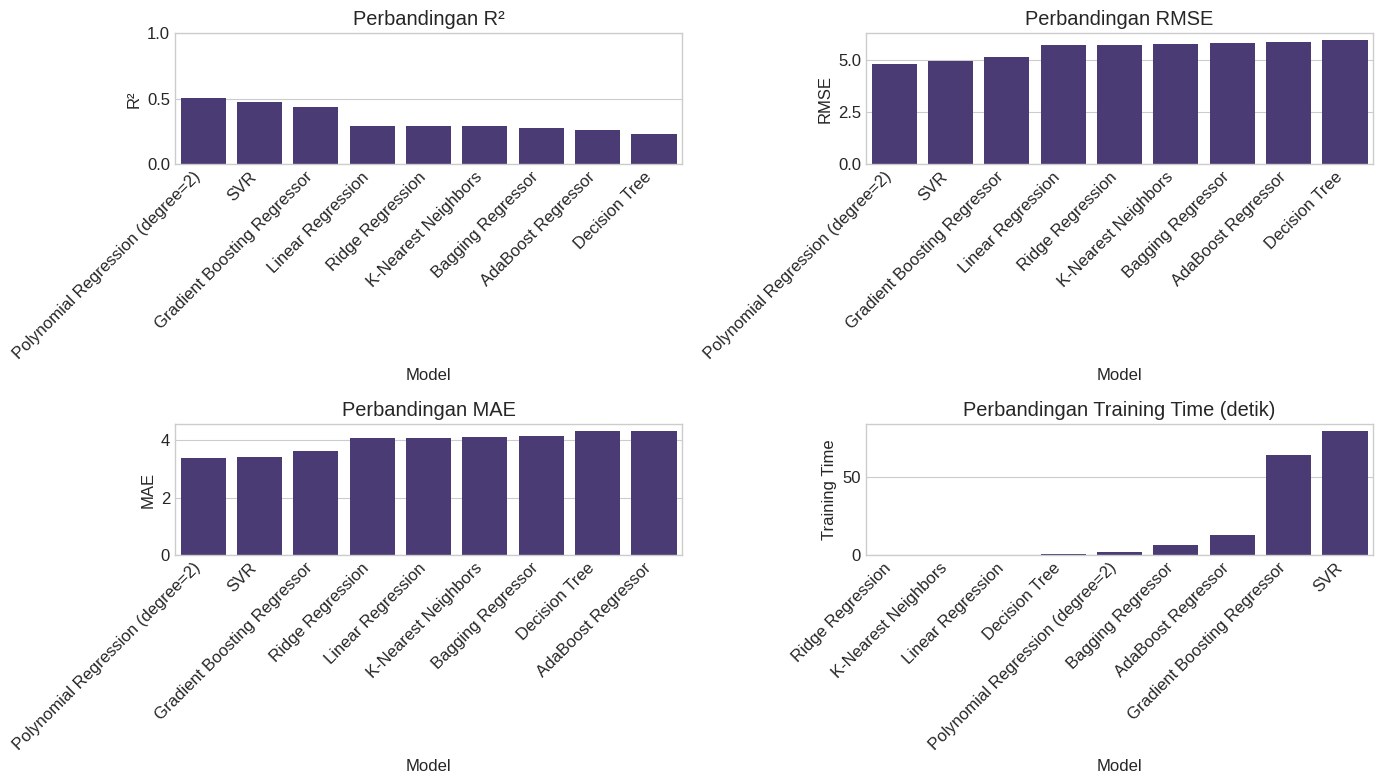

In [15]:
# Ringkasan hasil
results_df = pd.DataFrame(results)
print("\n" + "="*50)
print("RINGKASAN HASIL EVALUASI MODEL")
print("="*50)

# Tampilkan hasil diurutkan berdasarkan R²
print("\nPerbandingan Model (diurutkan berdasarkan R²):")
print(results_df.sort_values('R²', ascending=False))

# Visualisasi perbandingan metrik
plt.figure(figsize=(14, 8))

# Tampilkan R² untuk semua model
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='R²', data=results_df.sort_values('R²', ascending=False))
plt.title('Perbandingan R²')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)  # R² biasanya antara 0 dan 1

# Tampilkan RMSE untuk semua model
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='RMSE', data=results_df.sort_values('RMSE'))
plt.title('Perbandingan RMSE')
plt.xticks(rotation=45, ha='right')

# Tampilkan MAE untuk semua model
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='MAE', data=results_df.sort_values('MAE'))
plt.title('Perbandingan MAE')
plt.xticks(rotation=45, ha='right')

# Tampilkan Training Time untuk semua model
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Training Time', data=results_df.sort_values('Training Time'))
plt.title('Perbandingan Training Time (detik)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Model Terbaik

Mari kita identifikasi model terbaik berdasarkan metrik R² dan RMSE.

In [16]:
# Model terbaik berdasarkan R²
best_model_name = results_df.loc[results_df['R²'].idxmax()]['Model']
best_r2 = results_df.loc[results_df['R²'].idxmax()]['R²']
best_rmse = results_df.loc[results_df['R²'].idxmax()]['RMSE']

print(f"\nModel terbaik berdasarkan R²: {best_model_name}")
print(f"R² dari model terbaik: {best_r2:.4f}")
print(f"RMSE dari model terbaik: {best_rmse:.4f}")


Model terbaik berdasarkan R²: Polynomial Regression (degree=2)
R² dari model terbaik: 0.5044
RMSE dari model terbaik: 4.7984


### Feature Importance

Untuk model berbasis tree (Decision Tree, Random Forest, Gradient Boosting), kita dapat melihat feature importance untuk memahami fitur mana yang paling berpengaruh dalam prediksi.

In [17]:
# Feature importance untuk model tree-based
tree_based_models = ['Decision Tree', 'Random Forest', 'Gradient Boosting Regressor', 'AdaBoost Regressor', 'Bagging Regressor']
best_tree_model = None

for name in tree_based_models:
    if name in models and name == best_model_name:
        best_tree_model = models[name]
        break

if best_tree_model and hasattr(best_tree_model, 'feature_importances_'):
    # Buat DataFrame untuk feature importance
    importances = best_tree_model.feature_importances_
    feature_imp = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    # Visualisasi feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_imp)
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()

    print("\nTop 10 fitur paling penting:")
    print(feature_imp.head(10))
else:
    print("\nModel terbaik bukan model tree-based atau tidak memiliki atribut feature_importances_.")


Model terbaik bukan model tree-based atau tidak memiliki atribut feature_importances_.


# Analisis Soal

Berikut adalah analisis dari setiap soal terkait model regresi:

## 1. Strategi Mengatasi Underfitting

Jika model linear regression atau decision tree mengalami underfitting pada dataset ini, terdapat beberapa strategi untuk meningkatkan performa:

### Strategi 1: Transformasi Fitur
**Pendekatan**: Menambahkan transformasi non-linear pada fitur seperti log, sqrt, atau polynomial features.

**Implementasi untuk Linear Regression**:
- Menambahkan fitur polynomial (seperti x², x³) memungkinkan model linear menangkap hubungan non-linear
- Transformasi log atau power untuk menangani skewness dalam distribusi fitur

**Implementasi untuk Decision Tree**:
- Meskipun decision tree secara inheren dapat menangkap hubungan non-linear, transformasi dapat membantu dengan membuat pola lebih mudah diidentifikasi
- Rasio atau interaksi antar fitur dapat membantu tree membuat split yang lebih informatif

**Pengaruh pada Bias-Variance Tradeoff**:
- Menambahkan transformasi fitur **mengurangi bias** karena model menjadi lebih fleksibel
- Namun, ini **meningkatkan variance** karena model menjadi lebih kompleks
- Untuk linear regression, polynomial tingkat tinggi dapat menghasilkan overfitting jika tidak diregularisasi

### Strategi 2: Mengurangi Regularisasi atau Meningkatkan Kompleksitas Model
**Pendekatan**: Melonggarkan batasan pada model agar lebih fleksibel.

**Implementasi untuk Linear Regression**:
- Mengurangi atau menghilangkan regularisasi (Lasso, Ridge)
- Menggunakan model regresi non-linear seperti Spline atau MARS (Multivariate Adaptive Regression Splines)

**Implementasi untuk Decision Tree**:
- Meningkatkan `max_depth` untuk membuat tree lebih dalam
- Mengurangi `min_samples_split` dan `min_samples_leaf` untuk membuat split lebih detail
- Mengurangi `max_features` untuk mempertimbangkan lebih banyak fitur pada setiap split

**Pengaruh pada Bias-Variance Tradeoff**:
- Meningkatkan kompleksitas **menurunkan bias** karena model dapat lebih menyesuaikan dengan data
- Tetapi **meningkatkan variance** secara signifikan karena model menjadi lebih sensitif terhadap noise
- Model decision tree sangat rentan terhadap overfitting jika terlalu dalam

### Perbandingan Pendekatan
**Transformasi Fitur vs Peningkatan Kompleksitas Model**:

1. **Interpretabilitas**:
   - Transformasi fitur pada linear regression masih menghasilkan model yang relatif interpretable
   - Meningkatkan kompleksitas decision tree sangat mengurangi interpretabilitas

2. **Generalisasi**:
   - Transformasi fitur yang tepat dapat memberikan generalisasi lebih baik karena didasarkan pada pemahaman struktur data
   - Hanya meningkatkan kompleksitas tanpa insight domain knowledge berisiko overfitting

3. **Efektivitas untuk mengatasi underfitting**:
   - Transformasi fitur efektif jika underfitting disebabkan oleh ketidakmampuan model menangkap hubungan non-linear
   - Meningkatkan kompleksitas efektif jika underfitting disebabkan oleh batasan terlalu ketat pada model

Sebaiknya transformasi fitur dicoba terlebih dahulu karena lebih terkontrol dan interpretable, terutama jika ada domain knowledge tentang hubungan antar variabel. Jika masih underfitting, kompleksitas model dapat ditingkatkan secara bertahap dengan validasi untuk mencegah overfitting.

## 2. Alternatif Loss Function untuk Masalah Regresi

Selain Mean Squared Error (MSE), terdapat beberapa alternatif loss function untuk regresi:

### 1. Mean Absolute Error (MAE)
**Definisi**: Rata-rata dari nilai absolut error (|y_true - y_pred|)

**Keunggulan**:
- **Robust terhadap outlier** karena tidak mengkuadratkan error
- **Interpretabilitas langsung** sebagai rata-rata deviasi dalam unit target
- **Median sebagai estimator optimal**, cocok jika median lebih representatif daripada mean

**Kelemahan**:
- **Tidak differentiable pada titik nol**, yang bisa menimbulkan masalah optimisasi
- **Kurang sensitif terhadap perubahan kecil** pada prediksi
- **Tidak memberikan penalti lebih besar** untuk error besar seperti MSE

**Skenario penggunaan optimal**:
- Data dengan banyak outlier
- Kasus di mana semua error dianggap sama pentingnya terlepas dari besarnya
- Aplikasi di mana interpretabilitas error dalam unit asli sangat penting

### 2. Huber Loss
**Definisi**: Kombinasi dari MSE dan MAE, menggunakan MSE untuk error kecil dan MAE untuk error besar

**Keunggulan**:
- **Menggabungkan kelebihan MAE dan MSE** - robust terhadap outlier namun tetap differentiable
- **Parameter delta yang dapat diatur** untuk menentukan titik transisi antara perilaku kuadratik dan linear
- **Konvergensi yang lebih stabil** dalam proses optimisasi

**Kelemahan**:
- **Memerlukan tuning hyperparameter delta** yang tepat
- **Kurang interpretable** dibandingkan MAE atau MSE murni
- **Komputasi lebih kompleks** daripada MAE atau MSE

**Skenario penggunaan optimal**:
- Data dengan beberapa outlier (tapi tidak ekstrem)
- Kasus di mana perlu keseimbangan antara robustness dan smoothness
- Kasus di mana error kecil dan error besar perlu diperlakukan berbeda

### Perbandingan Keseluruhan
1. **MSE**: Cocok untuk:
   - Distribusi target yang Gaussian
   - Kasus di mana error besar harus diberi penalti lebih tinggi
   - Aplikasi di mana differentiability penting untuk optimisasi

2. **MAE**: Cocok untuk:
   - Data dengan outlier yang signifikan
   - Aplikasi di mana interpretasi langsung dari error diutamakan
   - Distribusi target dengan tail tebal seperti Laplacian

3. **Huber**: Cocok untuk:
   - Keseimbangan antara robustness dan smoothness
   - Kasus dengan moderate outliers
   - Ketika performa optimisasi dari MSE diinginkan tetapi dengan ketahanan terhadap outlier

Pemilihan loss function harus disesuaikan dengan karakteristik data dan tujuan aplikasi. Dalam konteks dataset ini, jika terdapat outlier dalam target yang tidak terdeteksi pada fase preprocessing, Huber loss atau MAE mungkin memberikan model yang lebih robust.

## 3. Metode Pengukuran Pentingnya Fitur

Tanpa mengetahui nama fitur, terdapat beberapa metode untuk mengukur kepentingan setiap fitur:

### 1. Koefisien Regresi Terstandarisasi
**Prinsip Teknikal**:
- Menstandarisasi semua fitur (mean=0, std=1)
- Melatih model regresi linear
- Koefisien yang dihasilkan menunjukkan perubahan dalam target (dalam unit standar deviasi) untuk setiap perubahan satu standar deviasi pada fitur

**Kelebihan**:
- Interpretasi langsung: menunjukkan efek relatif setiap fitur
- Komputasi efisien dan sederhana

**Keterbatasan**:
- Hanya valid untuk hubungan linear
- Dapat menyesatkan jika terdapat multikolinearitas
- Tidak menangkap hubungan non-linear atau interaksi

### 2. Feature Importance Berdasarkan Impurity Reduction
**Prinsip Teknikal**:
- Digunakan dalam model tree-based (Decision Tree, Random Forest)
- Mengukur seberapa banyak impurity (seperti MSE dalam regresi) berkurang setelah splitting pada fitur tertentu
- Impurity reduction dari semua node yang menggunakan fitur tersebut dijumlahkan dan dinormalisasi

**Kelebihan**:
- Menangkap hubungan non-linear
- Robust terhadap skala fitur
- Tidak terpengaruh multikolinearitas

**Keterbatasan**:
- Bias terhadap fitur dengan kardinalitas tinggi
- Cenderung overestimate kepentingan fitur yang korelasi
- Tidak memberikan arah hubungan (positif/negatif)

### 3. Permutation Importance
**Prinsip Teknikal**:
- Mengacak (permute) nilai-nilai suatu fitur sehingga hubungannya dengan target terganggu
- Mengukur penurunan performa model setelah pengacakan
- Fitur yang lebih penting akan menyebabkan penurunan performa lebih besar ketika diacak

**Kelebihan**:
- Model-agnostic: dapat digunakan dengan model apapun
- Menangkap hubungan non-linear dan interaksi
- Robust terhadap korelasi antar fitur (lebih dari impurity-based)

**Keterbatasan**:
- Komputasi intensif untuk dataset besar
- Hasil dapat bervariasi tergantung pengacakan acak
- Tidak memberikan arah hubungan

### 4. SHAP (SHapley Additive exPlanations) Values
**Prinsip Teknikal**:
- Berdasarkan teori game untuk alokasi adil dari "kontribusi"
- Menghitung kontribusi marginal setiap fitur untuk setiap prediksi
- Mengagregatkan kontribusi pada semua kombinasi fitur yang mungkin

**Kelebihan**:
- Konsisten secara teoretis dan memiliki dasar matematis yang kuat
- Memberikan kepentingan global dan lokal (per prediksi)
- Memperlihatkan arah dan besarnya dampak fitur

**Keterbatasan**:
- Sangat komputasi intensif
- Implementasi praktis menggunakan pendekatan/aproksimasi
- Interpretasi bisa kompleks

Untuk konteks dataset ini, metode permutation importance mungkin paling seimbang dalam menangkap hubungan kompleks tanpa asumsi model tertentu, terutama karena nama fitur tidak diketahui sehingga domain knowledge tidak dapat digunakan untuk interpretasi.

## 4. Desain Eksperimen untuk Pemilihan Hyperparameter Optimal

Untuk memilih hyperparameter optimal seperti learning rate untuk SGDRegressor atau max_depth untuk Decision Tree, berikut adalah desain eksperimen yang efektif:

### Strategi Pemilihan Hyperparameter
1. **Grid Search Cross-Validation**
   - Mendefinisikan grid nilai hyperparameter yang akan dieksplorasi
   - Melakukan cross-validation untuk setiap kombinasi hyperparameter
   - Memilih kombinasi dengan performa terbaik

2. **Random Search Cross-Validation**
   - Mengambil sampel acak dari rentang hyperparameter
   - Mungkin lebih efisien dari grid search untuk ruang hyperparameter besar
   - Efektif untuk menemukan area penting dalam ruang hyperparameter

3. **Bayesian Optimization**
   - Membuat model probabilistik dari fungsi objektif
   - Secara sekuensial memilih hyperparameter yang menjanjikan
   - Memanfaatkan informasi dari evaluasi sebelumnya

### Implementasi Konkret
Untuk Decision Tree Regressor:

In [18]:
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    DecisionTreeRegressor(),
    param_grid,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

### Analisis Tradeoff

**1. Komputasi vs. Ketelitian**
- **Grid Search**: Komprehensif tetapi sangat komputasi intensif
- **Random Search**: Efisiensi komputasi lebih baik, kemungkinan melewatkan optimal
- **Bayesian**: Komputasi moderat dengan fokus pada area menjanjikan
- **Tradeoff**: Untuk dataset besar atau model kompleks, random search mungkin lebih praktis

**2. Stabilitas Pelatihan**
- Penggunaan K-Fold Cross-Validation meningkatkan stabilitas
- Penentuan K yang optimal: lebih besar = lebih stabil tetapi lebih mahal
- Stratifikasi jika distribusi target tidak merata
- Rentang nilai hyperparameter harus cukup lebar namun masuk akal

**3. Generalisasi vs. Overfitting pada Validation Set**
- Risiko: Hyperparameter bisa optimal untuk validation set tetapi tidak pada data baru
- Solusi: Menggunakan nested cross-validation
- Outer CV untuk evaluasi model, inner CV untuk tuning hyperparameter
- Trade-off: Komputasi jauh lebih intensif

**4. Hyperparameter Spesifik**

Untuk `max_depth` pada Decision Tree:
- Nilai rendah: underfitting, bias tinggi, variance rendah, generalisasi mungkin lebih baik
- Nilai tinggi: overfitting, bias rendah, variance tinggi, performa training sangat baik
- Trade-off: Kedalaman yang optimal biasanya berada di titik di mana peningkatan training score tidak lagi menghasilkan peningkatan validation score

Untuk `learning_rate` pada model gradient-based:
- Nilai rendah: pelatihan stabil tetapi konvergensi lambat
- Nilai tinggi: konvergensi cepat tetapi berisiko tidak stabil atau melewati optimal
- Trade-off: Learning rate terbaik biasanya yang memberikan konvergensi stabil dalam waktu pelatihan yang wajar

### Rekomendasi Final
1. Mulai dengan Random Search untuk mengeksplorasi ruang hyperparameter secara luas
2. Gunakan Bayesian Optimization untuk fine-tuning pada area menjanjikan
3. Validasi model final dengan holdout test set yang belum digunakan dalam proses tuning
4. Untuk dataset ini yang ukurannya moderat, pendekatan ini memberikan keseimbangan yang baik antara efisiensi komputasi dan kualitas hasil

## 5. Mengatasi Residual Non-Linear dan Heteroskedastisitas

Jika residual plot model linear regression menunjukkan pola non-linear dan heteroskedastisitas, berikut langkah-langkah yang dapat diambil:

### 1. Transformasi Data

**a. Transformasi Variabel Target (Y)**
- **Log transformation**: Y' = log(Y) - efektif jika distribusi target skewed ke kanan
- **Box-Cox transformation**: Y' = (Y^λ - 1)/λ - generalisasi transformasi power
- **Square root**: Y' = √Y - untuk data yang mengikuti distribusi Poisson

**b. Transformasi Prediktor (X)**
- **Log transformation**: X' = log(X) - untuk hubungan eksponensial
- **Polynomial terms**: X' = X² - untuk hubungan kuadratik
- **Reciprocal**: X' = 1/X - untuk hubungan hiperbolik

**c. Transformasi Spesifik untuk Heteroskedastisitas**
- **Weighted Least Squares**: Memberikan bobot lebih rendah pada observasi dengan variabilitas tinggi
- **Variance-stabilizing transformations**: log(Y) jika varians proporsional dengan mean

### 2. Mengubah Model yang Dipakai

**a. Model Non-Linear**
- **Generalized Additive Models (GAM)**: Memodelkan hubungan non-linear dengan splines
- **Support Vector Regression dengan kernel non-linear**: Kernel RBF untuk menangkap pola kompleks
- **Decision Tree-based models**: Random Forest atau Gradient Boosting yang secara alami menangkap non-linearitas

**b. Model Khusus untuk Heteroskedastisitas**
- **Generalized Least Squares (GLS)**: Mempertimbangkan struktur varians-kovarians
- **Robust Regression**: Huber regression atau Quantile regression kurang sensitif terhadap heteroskedastisitas
- **ARCH/GARCH models**: Untuk data time series dengan volatilitas yang berubah-ubah

### 3. Pendekatan Kombinasi

**a. Pipeline Transformasi & Model**

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor

# Untuk transformasi target
model = TransformedTargetRegressor(
    regressor=LinearRegression(),
    transformer=PowerTransformer(method='box-cox')
)

# Atau untuk transformasi fitur
pipeline = Pipeline([
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('poly', PolynomialFeatures(degree=2)),
    ('regressor', LinearRegression())
])

**b. Feature Engineering Manual**
- Membuat interaksi fitur yang bermakna berdasarkan exploratory data analysis
- Menambahkan fitur non-linear seperti sin, cos untuk pola siklik
- Membuat rasio atau produk antar fitur yang relevan secara domain

### 4. Evaluasi dan Diagnostik

**a. Setelah Transformasi**
- Periksa kembali plot residual untuk memastikan pola non-linear berkurang
- Uji heteroskedastisitas formal (Breusch-Pagan test atau White test)
- Bandingkan metrik evaluasi (RMSE, R²) antara model original dan yang ditransformasi

**b. Pemilihan Metode Terbaik**
- Cross-validation untuk membandingkan berbagai transformasi
- Monitoring distribusi residual untuk memastikan normalitas
- Evaluasi tradeoff antara kompleksitas model dan interpretabilitas

### Contoh Konkret untuk Dataset Ini

Jika residual plot menunjukkan pola non-linear dan heteroskedastisitas, langkah-langkah spesifik untuk dataset ini adalah:

1. **Transformasi Target**: Coba Box-Cox transformation pada variabel target
2. **Tambahkan Fitur Non-Linear**: Buat fitur polinomial dan interaksi
3. **Evaluasi Model Non-Linear**: Bandingkan dengan Gradient Boosting yang sudah terbukti performa baik
4. **Weighted Regression**: Jika tetap heteroskedastisitas, implementasikan weighted regression dengan bobot inversely proportional terhadap varians residual

Keputusan optimal sering merupakan keseimbangan antara ketepatan model, interpretabilitas, dan kompleksitas implementasi. Untuk aplikasi di mana interpretabilitas sangat penting, transformasi data yang tepat dengan model linear masih mungkin menjadi pilihan terbaik. Untuk kasus di mana akurasi prediksi adalah prioritas utama, beralih ke model non-linear seperti Gradient Boosting adalah solusi yang lebih efektif.